In [1]:
import sys
import os

package_path="C:\\Users\\Olej0\\OneDrive\\Dokumenter\\TFT_Model\\pytorch-forecasting"



# Check if the directory exists
if os.path.exists(package_path):
    # Add the package path to sys.path
    sys.path.append(package_path)


print(sys.path)

import pandas as pd
import torch
import lightning.pytorch as pl
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer,TorchNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss,MultiHorizonMetric
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters




['C:\\Users\\Olej0\\OneDrive\\Dokumenter\\TFT_Model', 'C:\\Python311\\python311.zip', 'C:\\Python311\\DLLs', 'C:\\Python311\\Lib', 'C:\\Python311', 'C:\\Users\\Olej0\\OneDrive\\Dokumenter\\TFT_Model\\pytorch-forecasting\\myenv', '', 'C:\\Users\\Olej0\\OneDrive\\Dokumenter\\TFT_Model\\pytorch-forecasting\\myenv\\Lib\\site-packages', 'C:\\Users\\Olej0\\OneDrive\\Dokumenter\\TFT_Model\\pytorch-forecasting\\myenv\\Lib\\site-packages\\win32', 'C:\\Users\\Olej0\\OneDrive\\Dokumenter\\TFT_Model\\pytorch-forecasting\\myenv\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\Olej0\\OneDrive\\Dokumenter\\TFT_Model\\pytorch-forecasting\\myenv\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\Olej0\\OneDrive\\Dokumenter\\TFT_Model\\pytorch-forecasting']


C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Read & Transform Data

In [161]:
import numpy as np
df=pd.read_csv("Final_Dataset.csv").iloc[:,1:]

"""Energy_df=pd.read_csv("FINAL_ENERGY_PRODUCTION_DAILY").iloc[:,1:]
Electricity_df=pd.read_csv("FINAL_electricity_spot").iloc[:,1:]
Electricity_df"""
targets=df.iloc[:,-1:]
df=df.iloc[:,0:-1]

df=df.dropna()

merged_df = df


merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['month'] = merged_df['Date'].dt.month.astype(str)
merged_df['day_of_week'] = merged_df['Date'].dt.dayofweek.astype(str)
merged_df['Year'] = merged_df['Date'].dt.year.astype(str)
merged_df['Quarter'] = merged_df['Date'].dt.quarter.astype(str)
merged_df["time_idx"] = merged_df.index.tolist()
column_to_move = merged_df['time_idx']
merged_df = merged_df.drop('time_idx', axis=1)

# Step 3: Reinsert the column at the beginning
merged_df.insert(1, 'time_idx', column_to_move)
data=merged_df
data['Is_default'] = np.where((data['Target'] == 0.000000), "1", "0")
data["constant"]=42



data=data.dropna()

a1=np.array(data.columns[2:-6])
a2=np.array(data.columns[-12:-10])
print(a2)
print(a1)

cols=[]
for i in range(len(a1)):
    print(a1[i])
    cols.append(a1[i])
    data[a1[i]] =pd.to_numeric(data[a1[i]])

cols1=[]
for i in range(len(a2)):
  cols1.append(a2[i])
  data[a2[i]] =pd.to_numeric(data[a2[i]])

cols1.append("time_idx")
cols1.append("Weighted_Average_Temperature")
cols1.append('Average_temp')
cols1.append( 'Average_temp_EMA30')
cols1.append( 'Average_temp_EMA60')
cols1.append( 'Average_temp_EMA100')
cols1.append( 'Average_temp_EMA_mean')

cols = [item for item in cols if item not in cols1]
features=pd.read_csv("Features.csv").iloc[:,1:]
print(features)
features=features["Features"].values
cols=[item for item in cols if item in features]

print(cols)
print(cols1)

['Cooling_req' 'Heating_req']
['Electricity_price' 'Exchange' 'CO2_spot' 'EU_spark_spread'
 'EU_clean_spark_spread' 'Oil_Price' 'Oil_Volume' 'Sun_energy'
 'Wind_energy' 'Average_temp' 'Weighted_Average_Temperature' 'Full (%)'
 'Net_Injection' 'Shipping_price' 'Gas_consumtion' 'Google_data'
 'Industrial_prod' 'PINDUINDEXM' 'Target' 'EU_clean_spark_spread_EMA30'
 'EU_clean_spark_spread_EMA60' 'EU_clean_spark_spread_EMA100'
 'EU_clean_spark_spread_EMA_mean' 'Average_temp_EMA30'
 'Average_temp_EMA60' 'Average_temp_EMA100' 'Average_temp_EMA_mean'
 'Net_Injection_EMA30' 'Net_Injection_EMA60' 'Net_Injection_EMA100'
 'Net_Injection_EMA_mean' 'Oil_Price_EMA30' 'Oil_Price_EMA60'
 'Oil_Price_EMA100' 'Oil_Price_EMA_mean' 'Wind_energy_EMA30'
 'Wind_energy_EMA60' 'Wind_energy_EMA100' 'Wind_energy_EMA_mean'
 'Electricity_price_EMA30' 'Electricity_price_EMA60'
 'Electricity_price_EMA100' 'Electricity_price_EMA_mean'
 'PINDUINDEXM_EMA30' 'PINDUINDEXM_EMA60' 'PINDUINDEXM_EMA100'
 'PINDUINDEXM_EMA_mean' 

# Make TimeSeriesDataSet object

In [221]:
max_prediction_length = 30
max_encoder_length = 100
training_cutoff = data["time_idx"].max() - max_prediction_length

lags={
    "Target":[1,2,3,4,5,6,7,8,9,10,28,29,30,31,60,364,365,366],


}

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Target",
    group_ids=["constant"],  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_encoder_length=max_encoder_length // 2,

    
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["day_of_week", "month","Year","Quarter","Is_default"],
    time_varying_known_reals=cols1,
    time_varying_unknown_reals=cols,
    target_normalizer=TorchNormalizer(),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,





)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 5, num_workers=8)
data_df = training.data

# Display the first few rows of the data
print(data_df)

{'reals': tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.1595, -1.3242, -1.1877],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.1624, -1.3242, -1.1877],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.1704, -1.3242, -1.1877],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.2400, -0.0649,  0.6037],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.2487, -0.1510,  0.0866],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.2487, -0.9126, -0.2526]]), 'categoricals': tensor([[ 1,  0,  0,  0,  0],
        [ 2,  0,  0,  0,  0],
        [ 3,  0,  0,  0,  0],
        ...,
        [ 3,  8, 11,  1,  0],
        [ 4,  8, 11,  1,  0],
        [ 5,  9, 11,  2,  0]]), 'groups': tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]), 'target': [tensor([ 0.1404, -0.1302, -0.0822,  ...,  0.0282, -0.0144,  0.0549])], 'weight': None, 'time': tensor([   0,    1,    2,  ..., 4195, 4196, 4197])}


In [4]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=10,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=10,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 47.7k


C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [189]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=50,
    max_epochs=10,
    hidden_size_range=(32,64),
    hidden_continuous_size_range=(32,64),
    attention_head_size_range=(4, 16),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.2, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time


# show best hyperparameters
print(study.best_trial.params)

[I 2023-10-15 00:49:10,978] A new study created in memory with name: no-name-daa64faf-a72f-4cad-bb77-db7755b91cf4
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:148: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout=trial.suggest_uniform("dropout", *dropout_range),
C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Olej0\One

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2023-10-15 05:50:06,946] Trial 7 finished with value: 0.01740037463605404 and parameters: {'gradient_clip_val': 0.5790839557512144, 'hidden_size': 38, 'dropout': 0.23266934143877976, 'hidden_continuous_size': 32, 'attention_head_size': 10, 'learning_rate': 0.027549804694457614}. Best is trial 0 with value: 0.015367688611149788.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\optuna_test\trial_8 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2023-10-15 06:20:49,201] Trial 8 finished with value: 0.01725035533308983 and 

{'gradient_clip_val': 0.3666981517170834, 'hidden_size': 35, 'dropout': 0.22632014780768187, 'hidden_continuous_size': 32, 'attention_head_size': 5, 'learning_rate': 0.009191845457069185}


# Fit Model

In [4]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(torch.cuda.is_available())

False


In [222]:

from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-6, patience=4, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard
from lightning.pytorch import Trainer, seed_everything

seed_everything(42, workers=True)

trainer = pl.Trainer(
    max_epochs=8,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    deterministic=True,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=64,
    attention_head_size=14,
    dropout=0.2,
    hidden_continuous_size=64,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
    
    
    
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(

   | Name                               | Type                            | Params
-----------------------------------------------

Number of parameters in network: 1521.0k
Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [04:01<00:00,  3.66s/it, v_num=117, train_loss_step=0.0132]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [04:22<00:00,  3.97s/it, v_num=117, train_loss_step=0.00946, val_loss=0.0186, train_loss_epoch=0.0167]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [04:13<00:00,  3.84s/it, v_num=117, train_loss_step=0.0149, val_loss=0.0181, train_loss_epoch=0.0132]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████

Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [05:06<00:00,  4.65s/it, v_num=117, train_loss_step=0.0124, val_loss=0.0157, train_loss_epoch=0.0105]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [05:07<00:00,  4.66s/it, v_num=117, train_loss_step=0.0124, val_loss=0.0157, train_loss_epoch=0.0105]


# Accuracy of full model

tensor([[4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209,
         4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221,
         4222, 4223, 4224, 4225, 4226, 4227]])
[ 0.          0.00658981 -0.03679345 -0.01949603  0.01294423 -0.0670758
 -0.00214166  0.          0.00823552 -0.0591259  -0.05293992 -0.06383654
 -0.03801897 -0.0071739   0.          0.00755005 -0.04775647  0.04850835
  0.01232509  0.02782024  0.04620818  0.          0.00137789  0.02850549
  0.07568394 -0.04309919 -0.0746063  -0.09050667  0.          0.0003819 ]
         p0        p1        p2        p3        p4        p5        p6  \
0  0.000022  0.003047  0.030132  0.013286  0.025307 -0.001151  0.000921   

         p7        p8        p9  ...       p20       p21       p22       p23  \
0 -0.000935  0.002827 -0.004506  ...  0.011132  0.000174  0.002187  0.036857   

        p24       p25       p26       p27       p28       p29  
0  0.014236  0.020059 -0.024459  0.004231 -0.00015

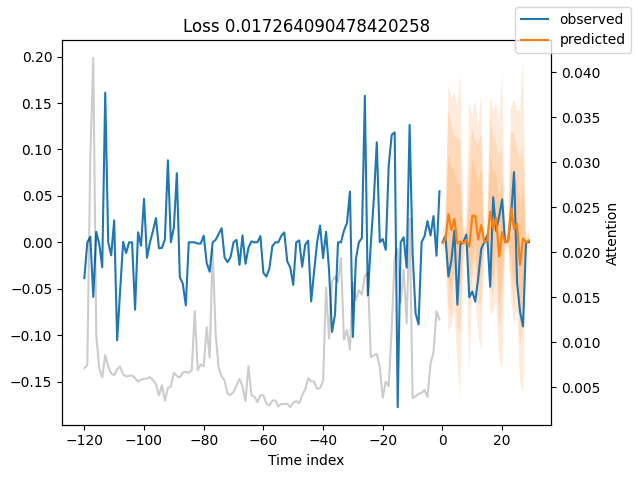

In [217]:
"""best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)"""
raw_predictions =tft.predict(val_dataloader, mode="raw", return_x=True)
pred=tft.predict(val_dataloader, mode="prediction", return_x=True, return_y =True)
tensor_array = pred.output.numpy() # Convert to NumPy array
targets=pred.y[0].numpy()
print(pred.x['decoder_time_idx'])
print(targets[0])
# Create a new DataFrame with the tensor data as a row
columns=[]
target_col=[]
for i in range(max_prediction_length):
    columns.append("p"+str(i))
    target_col.append("t"+str(i))
Predict_df = pd.DataFrame(tensor_array, columns=columns)
target_df=pd.DataFrame(targets, columns=target_col)
print(Predict_df )
print(target_df )
for idx in range(1):  # plot 10 examples
    tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    
    

[4198 4199 4200 4201 4202 4203 4204 4205 4206 4207 4208 4209 4210 4211
 4212 4213 4214 4215 4216 4217 4218 4219 4220 4221 4222 4223 4224 4225
 4226 4227]
[0.0, 0.00658981, -0.036793448, -0.019496031, 0.012944234, -0.0670758, -0.0021416561, 0.0, 0.00823552, -0.059125897, -0.052939918, -0.06383654, -0.03801897, -0.007173903, 0.0, 0.0075500547, -0.047756474, 0.048508354, 0.012325086, 0.027820243, 0.046208184, 0.0, 0.0013778851, 0.028505493, 0.075683944, -0.04309919, -0.0746063, -0.090506665, 0.0, 0.00038189805]
[2.1569063e-05, 0.0030465224, 0.030132202, 0.013286189, 0.025306543, -0.0011512531, 0.000921154, -0.0009345611, 0.0028270113, -0.0045059375, 0.028686678, 0.028384319, 0.0028744938, 0.018675705, 0.00019176706, 0.0021315375, 0.033006888, 0.014242928, 0.026545288, -0.0153180715, 0.011132121, 0.00017438924, 0.002187141, 0.036857054, 0.014235797, 0.020059137, -0.024458684, 0.0042305733, -0.00015476694, 0.0020761532]
MSE
0.0020314618
Benchmark
0.0016098833312131783


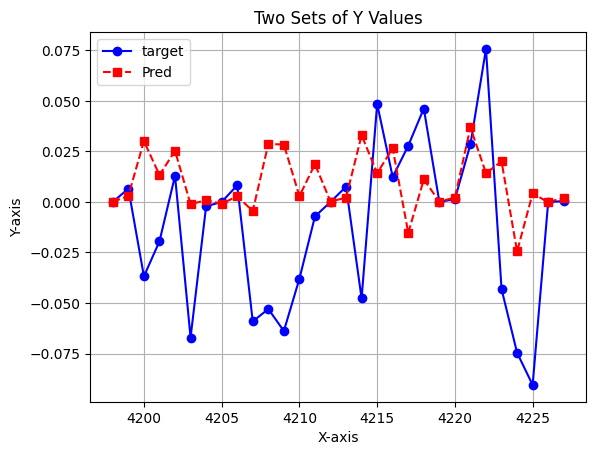

In [218]:
import matplotlib.pyplot as plt
print(pred.x['decoder_time_idx'].numpy()[0])

# Sample data

x_values = pred.x['decoder_time_idx'].numpy()[0]
y_values1 = []
for i in range(len(target_df.values[0])):
    y_values1.append(target_df.values[0][i])
print(y_values1)
y_values2 = []
for j in range(len(Predict_df.values[0])):
    y_values2.append(Predict_df.values[0][j])
print(y_values2)


ref=[0]*len(y_values2)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_values1, y_values2)
print("MSE")
print(mse)
print("Benchmark")
print(mean_squared_error(y_values1, ref))
# Create a line plot for the first set of Y values
plt.plot(x_values, y_values1, label='target', color='blue', linestyle='-', marker='o')

# Create a line plot for the second set of Y values
plt.plot(x_values, y_values2, label='Pred', color='red', linestyle='--', marker='s')

# Add labels and a legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Two Sets of Y Values')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


{'attention': tensor([0.0031, 0.0039, 0.0037, 0.0029, 0.0039, 0.0037, 0.0034, 0.0034, 0.0035,
        0.0036, 0.0029, 0.0040, 0.0037, 0.0037, 0.0033, 0.0036, 0.0040, 0.0029,
        0.0057, 0.0055, 0.0039, 0.0037, 0.0039, 0.0040, 0.0029, 0.0038, 0.0037,
        0.0039, 0.0033, 0.0036, 0.0046, 0.0028, 0.0041, 0.0046, 0.0043, 0.0032,
        0.0062, 0.0038, 0.0031, 0.0041, 0.0042, 0.0041, 0.0037, 0.0038, 0.0042,
        0.0028, 0.0037, 0.0035, 0.0034, 0.0031, 0.0035, 0.0036, 0.0025, 0.0035,
        0.0034, 0.0034, 0.0030, 0.0031, 0.0041, 0.0022, 0.0028, 0.0034, 0.0035,
        0.0032, 0.0036, 0.0033, 0.0026, 0.0037, 0.0036, 0.0034, 0.0035, 0.0036,
        0.0037, 0.0029, 0.0038, 0.0043, 0.0040, 0.0057, 0.0038, 0.0110, 0.0041,
        0.0049, 0.0050, 0.0046, 0.0047, 0.0049, 0.0058, 0.0038, 0.0041, 0.0036,
        0.0036, 0.0034, 0.0038, 0.0090, 0.0051, 0.0043, 0.0040, 0.0041, 0.0040,
        0.0057, 0.0058, 0.0044, 0.0046, 0.0048, 0.0051, 0.0042, 0.0039, 0.0041,
        0.0039, 0.0040, 0.

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x1625 with 1 Axes>,
 'decoder_variables': <Figure size 700x575 with 1 Axes>}

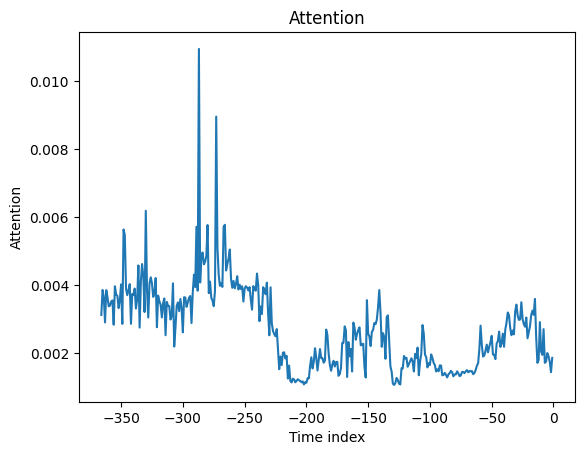

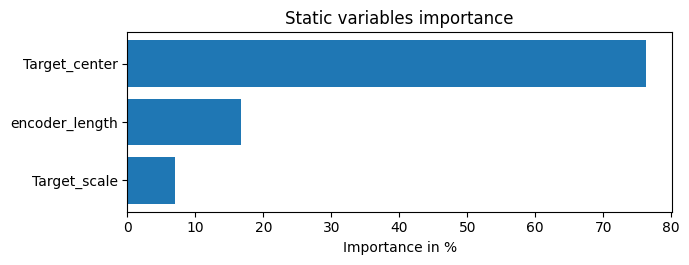

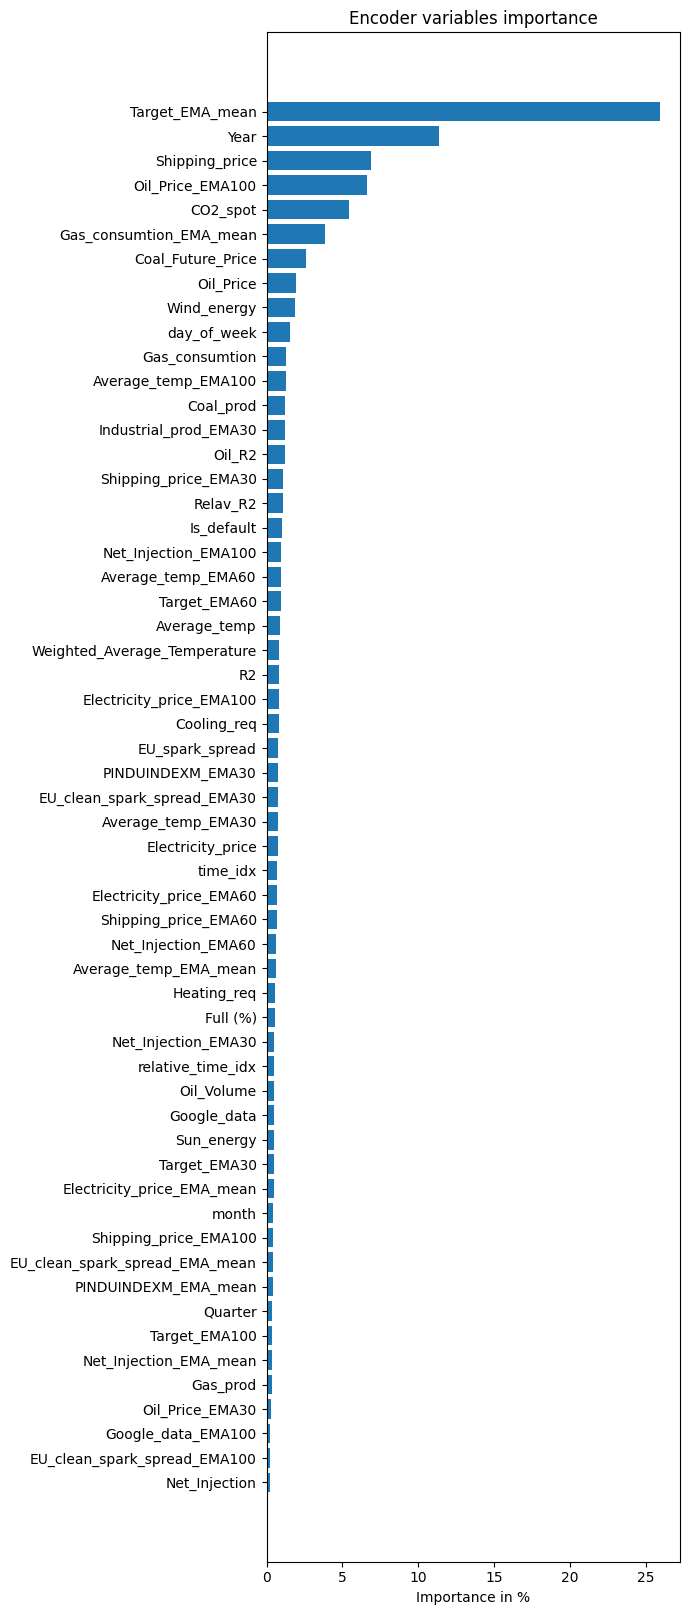

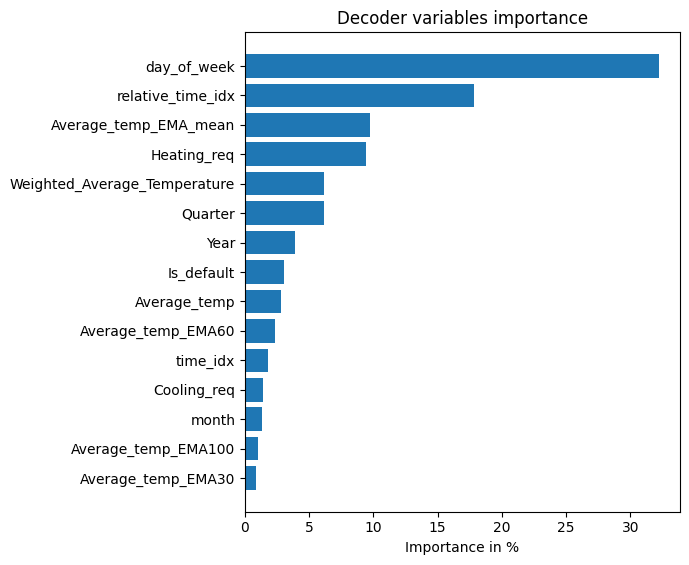

In [214]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="mean")
print(interpretation)
tft.plot_interpretation(interpretation)

# Test for other predictions

In [116]:

from datetime import datetime, timedelta# select last 24 months from data (max_encoder_length is 24)
time_idx_max=4236
enocder_inx_list=[]
for i in range(max_encoder_length+1):
    enocder_inx_list.append(time_idx_max-max_encoder_length-1+i)
decoder_inx_list=[]
for i in range(max_prediction_length):
    decoder_inx_list.append(time_idx_max+i)

encoder_data = data[lambda x: (x.time_idx >= enocder_inx_list[0])& (x.time_idx <= enocder_inx_list[-1]) ]
decoder_data = data[lambda x: (x.time_idx >= decoder_inx_list[0])& (x.time_idx <= decoder_inx_list[-1]) ]
print(decoder_inx_list)

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)



# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx ==time_idx_max]
last_data['Date'] = pd.to_datetime(last_data['Date'])

Decoder=pd.DataFrame(columns=last_data.columns)
print(last_data)
for i in range(max_prediction_length):
    df=pd.DataFrame(last_data.values,columns=last_data.columns)
    df["Date"]=df["Date"]+ timedelta(days=i)
    df["time_idx"]=df["time_idx"]+i
    Decoder = pd.concat([Decoder, df], ignore_index=True)
    
Decoder['month'] = Decoder['Date'].dt.month.astype(str)
Decoder['day_of_week'] = Decoder['Date'].dt.dayofweek.astype(str)
Decoder['Year'] = Decoder['Date'].dt.year.astype(str)
Decoder['Quarter'] = Decoder['Date'].dt.quarter.astype(str)


targets = data[data['time_idx'].isin(decoder_inx_list)]

Decoder['Is_default'] = targets["Is_default"].values
new_prediction_data = pd.concat([encoder_data, Decoder], ignore_index=True)
a1=np.array(new_prediction_data.columns[2:-6])



for i in range(len(a1)):
  new_prediction_data[a1[i]] =pd.to_numeric(new_prediction_data[a1[i]])




new_prediction_data['time_idx'] = new_prediction_data['time_idx'].astype(int)

print(new_prediction_data)

new_raw_predictions = tft.predict(new_prediction_data, mode="prediction", return_x=True)
print(new_raw_predictions.output.numpy()[0])

print(targets)
print(targets["Target"])
print(new_raw_predictions.x['decoder_time_idx'])


[4236, 4237, 4238, 4239, 4240, 4241, 4242, 4243, 4244, 4245, 4246, 4247, 4248, 4249, 4250, 4251, 4252, 4253, 4254, 4255, 4256, 4257, 4258, 4259, 4260, 4261, 4262, 4263, 4264, 4265]
           Date  time_idx  Electricity_price  Exchange  CO2_spot  \
4236 2023-08-09      4236           88.34875    1.0975     83.33   

      EU_spark_spread  EU_clean_spark_spread  Oil_Price  Oil_Volume  \
4236        27.652638              -9.012562      87.55      388299   

      Sun_energy  ...    EOAN         XOM       ONGC       EQNR  month  \
4236      276653  ...  10.945  108.669189  176.40239  31.627033      8   

      day_of_week  Year  Quarter  Is_default  constant  
4236            2  2023        3           0        42  

[1 rows x 83 columns]
          Date  time_idx  Electricity_price  Exchange  CO2_spot  \
0   2023-05-20      4155          46.809167    1.0804     86.67   
1   2023-05-21      4156          28.464167    1.0804     86.67   
2   2023-05-22      4157          97.331250    1.081

C:\Users\Olej0\AppData\Local\Temp\ipykernel_18732\1154220642.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_data['Date'] = pd.to_datetime(last_data['Date'])
C:\Users\Olej0\AppData\Local\Temp\ipykernel_18732\1154220642.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Decoder = pd.concat([Decoder, df], ignore_index=True)


[ 0.02019792  0.02969221  0.05182334 -0.12190618  0.00101774  0.00654954
  0.03197624  0.01674728  0.061714    0.07863595 -0.11372921  0.00066135
  0.00369846  0.02586236  0.06877965  0.05520912  0.01058052 -0.11859975
  0.0005543   0.00380793  0.02731347  0.00646289  0.04671665  0.02666997
 -0.00758919  0.00053499  0.00310975  0.00711089 -0.00301143  0.05988191]
           Date  time_idx  Electricity_price  Exchange  CO2_spot  \
4236 2023-08-09      4236          88.348750   1.09750    83.330   
4237 2023-08-10      4237         102.172500   1.09810    83.330   
4238 2023-08-11      4238         100.444167   1.09460    83.765   
4239 2023-08-12      4239          80.135000   1.09460    84.200   
4240 2023-08-13      4240          65.208750   1.09460    84.200   
4241 2023-08-14      4241         103.371667   1.09060    84.200   
4242 2023-08-15      4242          93.556667   1.09050    84.200   
4243 2023-08-16      4243         110.807083   1.08760    84.200   
4244 2023-08-17      4

C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


MSE
0.006508828755318075


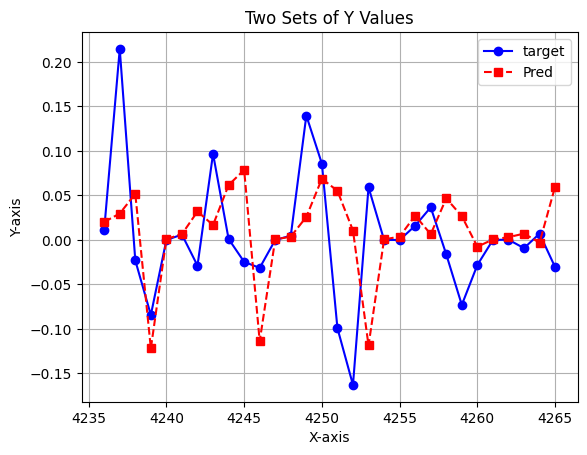

In [117]:
x_values = new_raw_predictions.x['decoder_time_idx'].numpy()[0]
y_values1 = targets["Target"].values
y_values2 = new_raw_predictions.output.numpy()[0]




from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_values1, y_values2)
print("MSE")
print(mse)
# Create a line plot for the first set of Y values
plt.plot(x_values, y_values1, label='target', color='blue', linestyle='-', marker='o')

# Create a line plot for the second set of Y values
plt.plot(x_values, y_values2, label='Pred', color='red', linestyle='--', marker='s')

# Add labels and a legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Two Sets of Y Values')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

{'attention': tensor([0.0864, 0.0616, 0.0540, 0.0436, 0.0175, 0.0129, 0.0045, 0.0049, 0.0070,
        0.0042, 0.0035, 0.0065, 0.0050, 0.0091, 0.0132, 0.0060, 0.0055, 0.0056,
        0.0096, 0.0232, 0.0711, 0.0977, 0.0186, 0.0172, 0.0146, 0.0089, 0.0068,
        0.0080, 0.0168, 0.0233, 0.0231, 0.0198, 0.0119, 0.0151, 0.0085, 0.0135,
        0.0090, 0.0100, 0.0076, 0.0067, 0.0047, 0.0043, 0.0086, 0.0059, 0.0069,
        0.0066, 0.0118, 0.0176, 0.0229, 0.0078, 0.0034, 0.0054, 0.0045, 0.0038,
        0.0027, 0.0027, 0.0038, 0.0049, 0.0045, 0.0046, 0.0204, 0.0053, 0.0074,
        0.0031, 0.0020, 0.0020, 0.0026, 0.0026, 0.0027, 0.0024, 0.0045, 0.0043,
        0.0052, 0.0050, 0.0051, 0.0104, 0.0046, 0.0046, 0.0038, 0.0033]), 'static_variables': tensor([0.0579, 0.6330, 0.3091]), 'encoder_variables': tensor([1.4027e-03, 1.3032e-03, 1.0195e-03, 1.9836e-03, 1.6747e-03, 1.8635e-03,
        1.4174e-03, 1.4615e-01, 6.5076e-04, 4.7056e-03, 1.4929e-03, 1.8032e-03,
        1.1241e-03, 1.0390e-02, 1.741

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x1750 with 1 Axes>,
 'decoder_variables': <Figure size 700x575 with 1 Axes>}

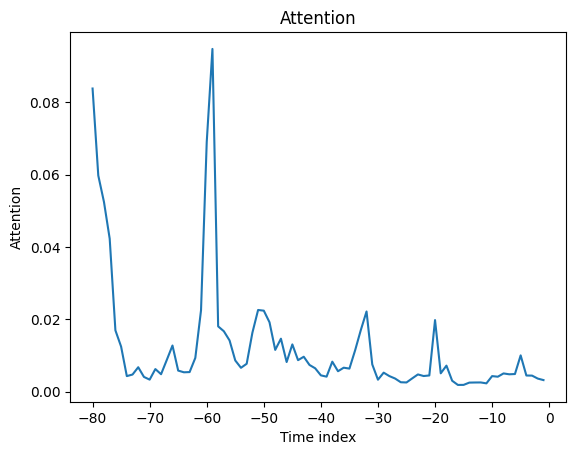

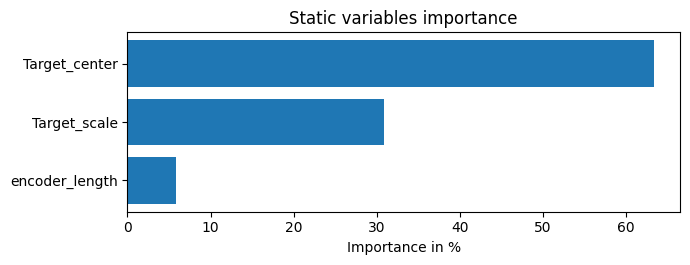

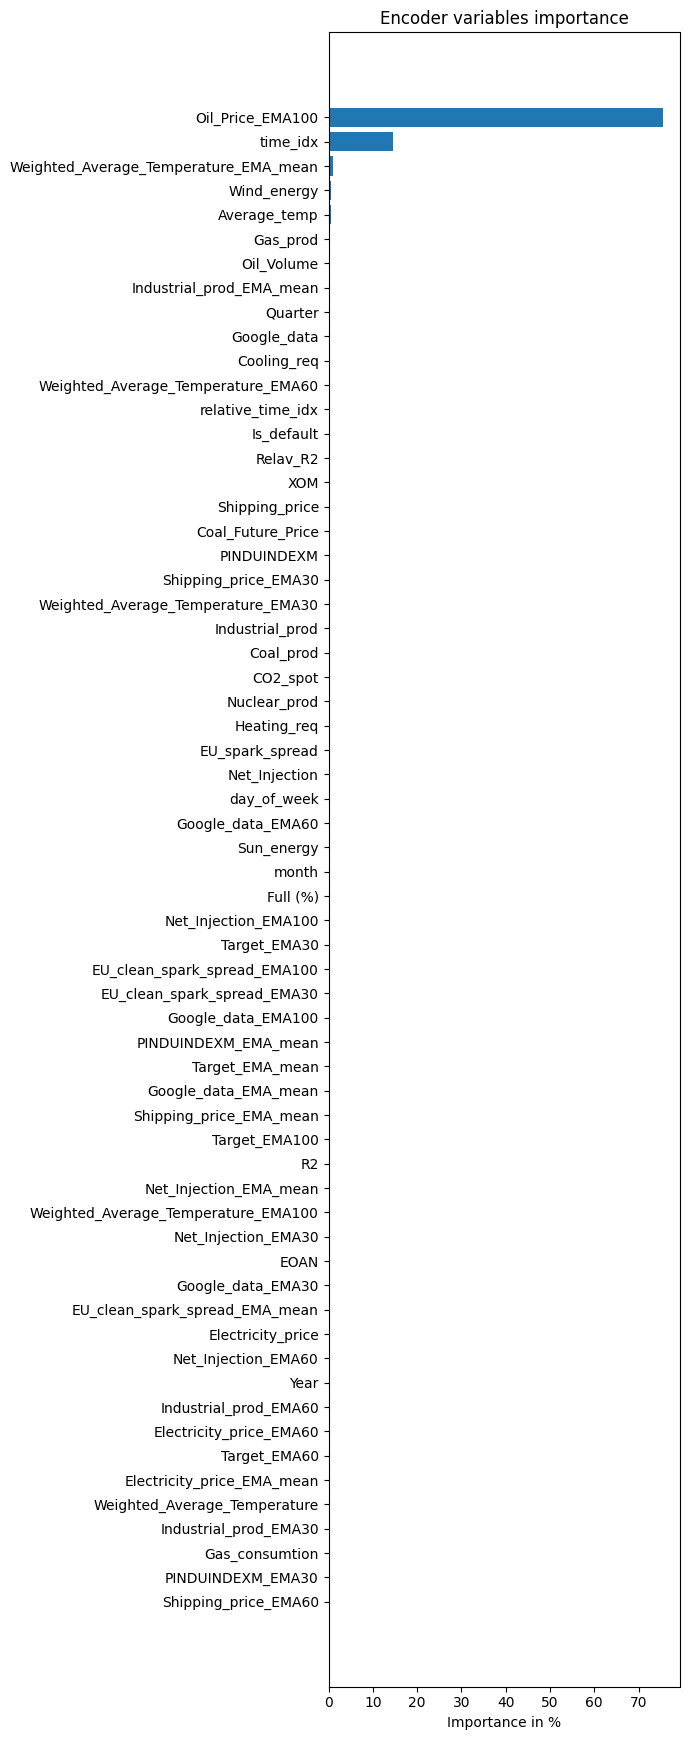

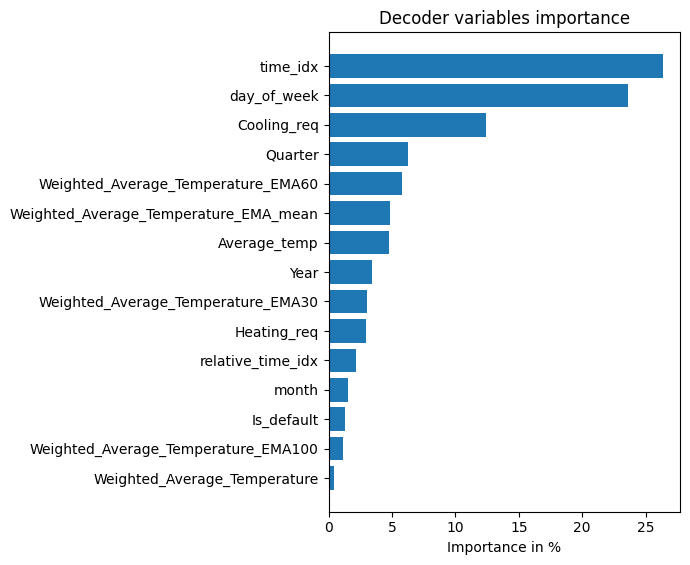

In [131]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="mean")
print(interpretation)
tft.plot_interpretation(interpretation)

C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\pytorch_forecasting\models\base_model.py:1865: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(**kwargs)


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Target_center': <Figure size 1000x500 with 2 Axes>,
 'Target_scale': <Figure size 1000x500 with 2 Axes>,
 'Cooling_req': <Figure size 1000x500 with 2 Axes>,
 'Heating_req': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'Weighted_Average_Temperature': <Figure size 1000x500 with 2 Axes>,
 'Average_temp': <Figure size 1000x500 with 2 Axes>,
 'Average_temp_EMA30': <Figure size 1000x500 with 2 Axes>,
 'Average_temp_EMA60': <Figure size 1000x500 with 2 Axes>,
 'Average_temp_EMA100': <Figure size 1000x500 with 2 Axes>,
 'Average_temp_EMA_mean': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'Electricity_price': <Figure size 1000x500 with 2 Axes>,
 'CO2_spot': <Figure size 1000x500 with 2 Axes>,
 'EU_spark_spread': <Figure size 1000x500 with 2 Axes>,
 'Oil_Price': <Figure size 1000x500 with 2 Axes>,
 'Oil_Volume': <Figure size 1000x500 with 2 Axes>,
 

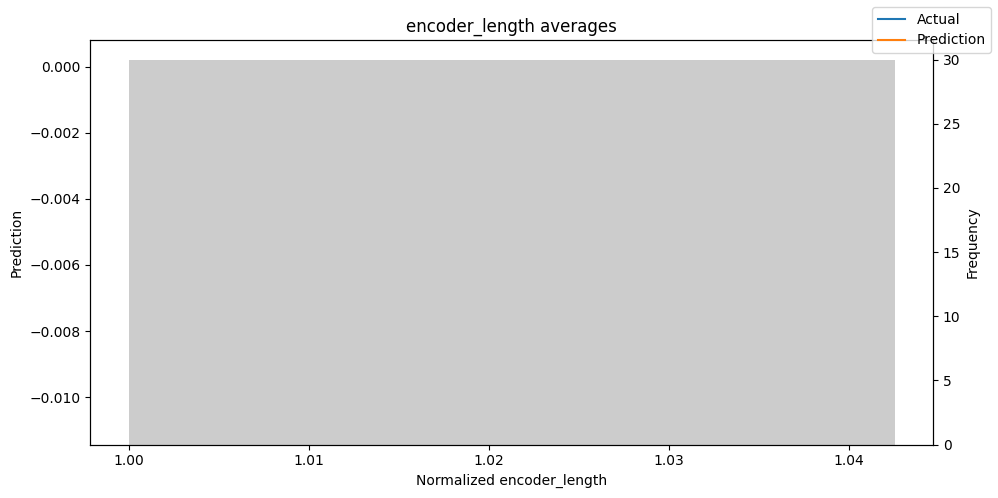

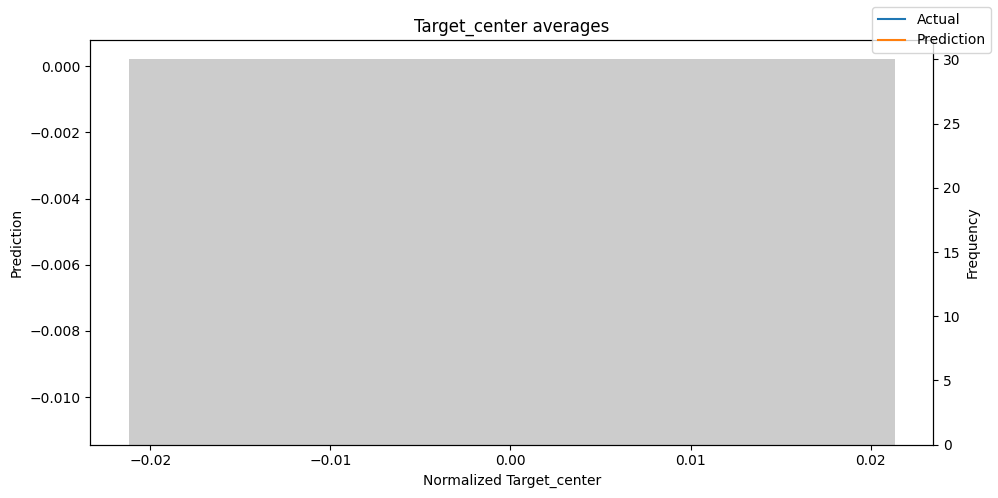

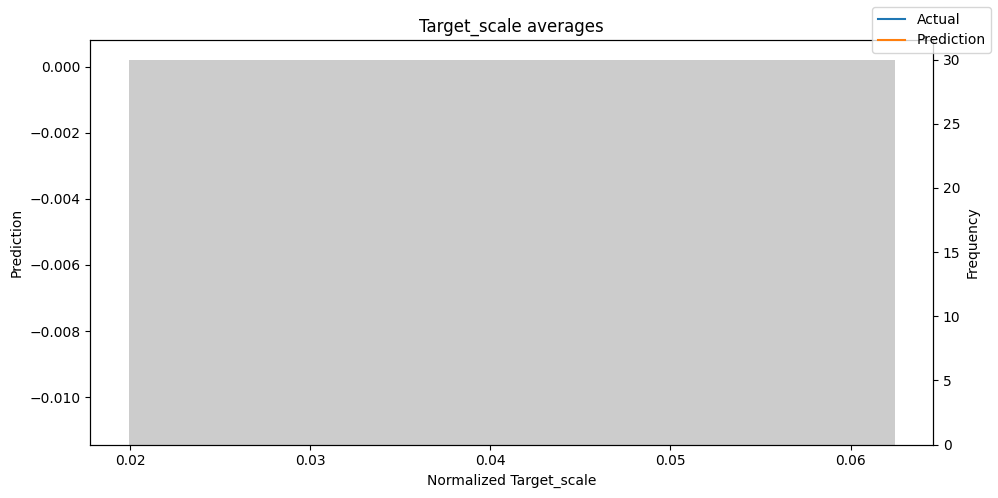

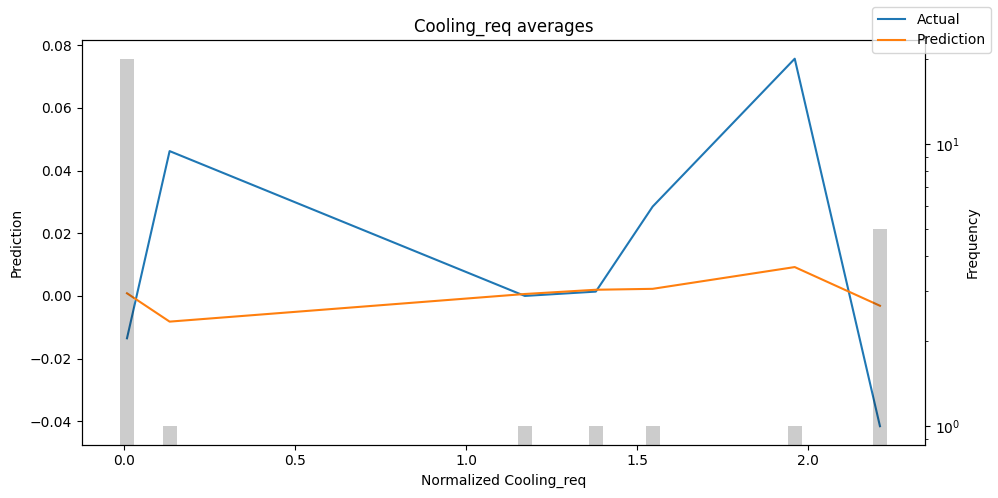

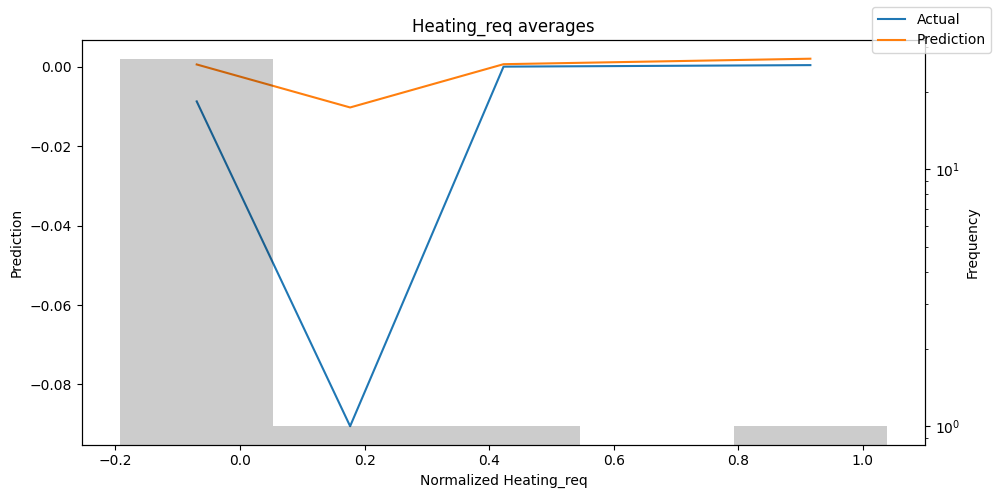

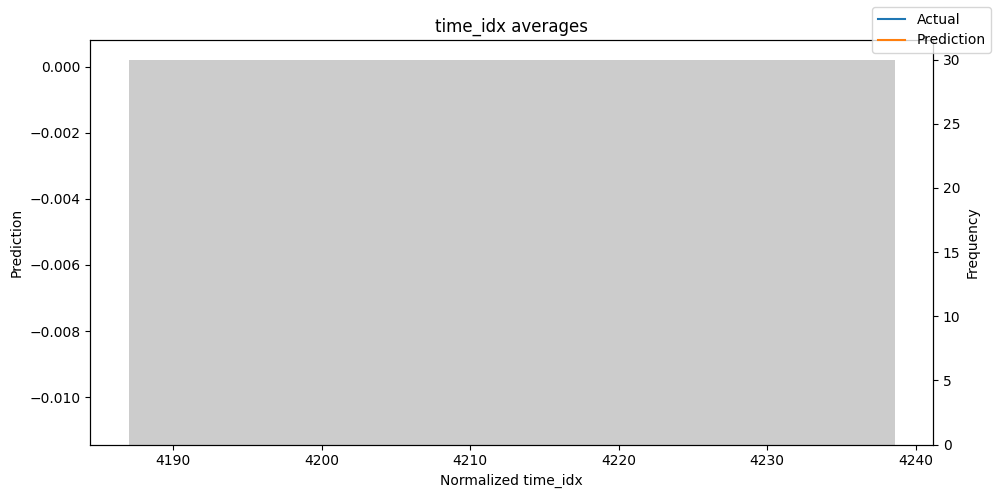

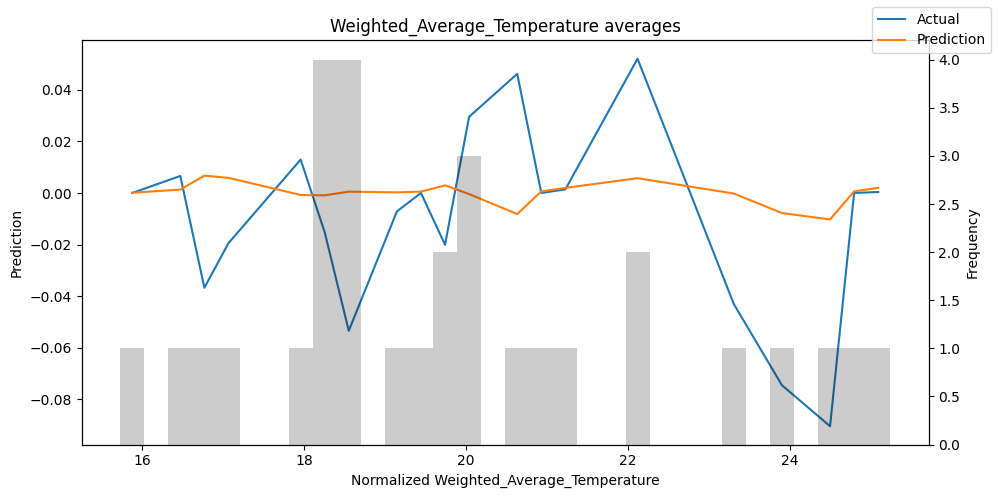

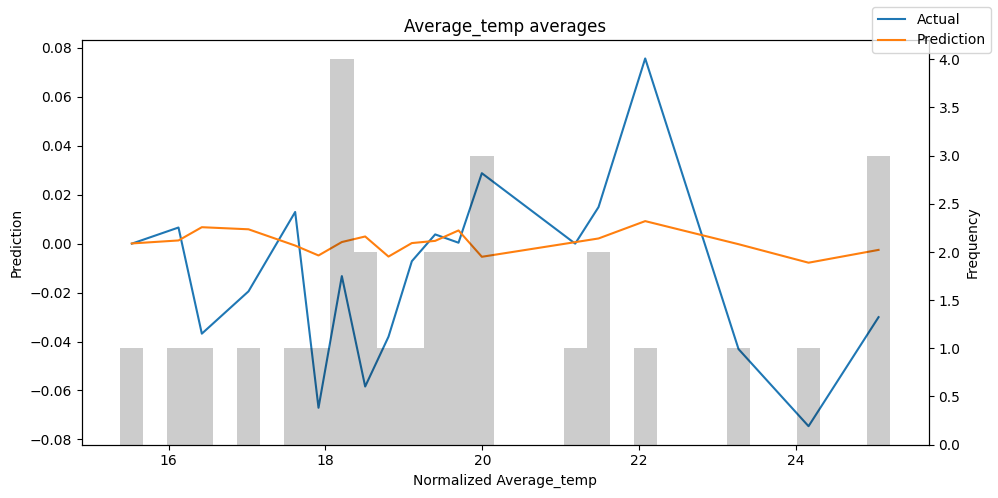

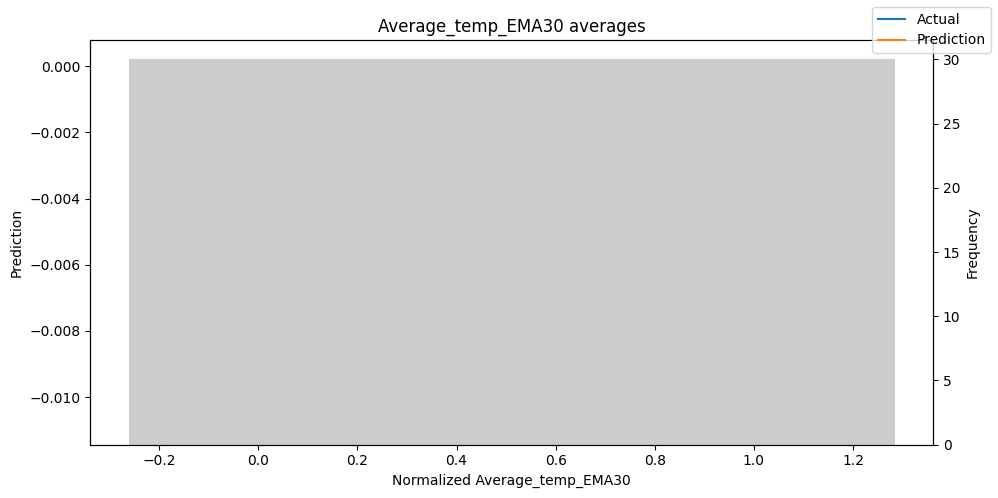

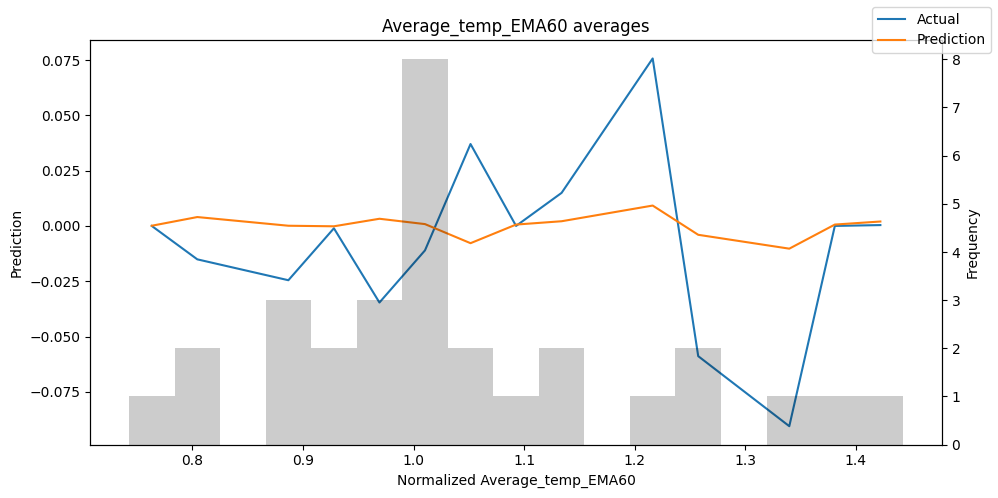

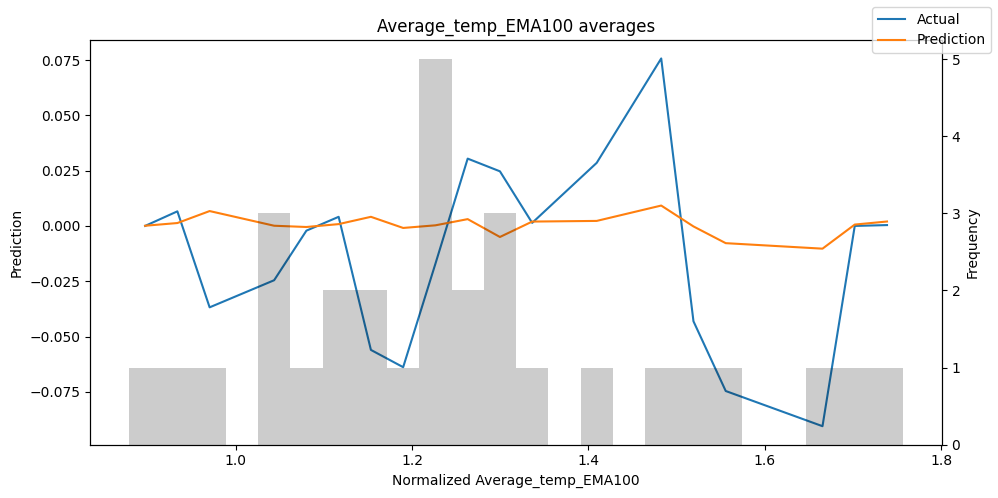

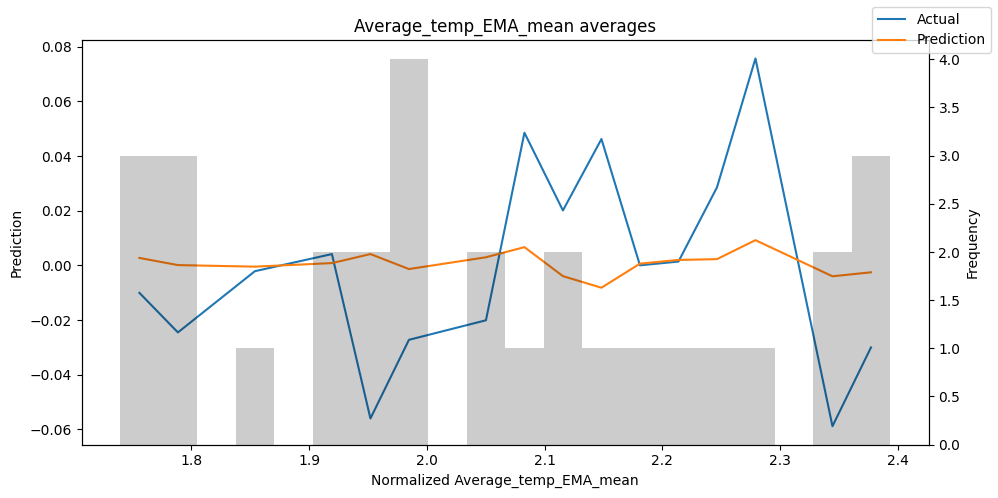

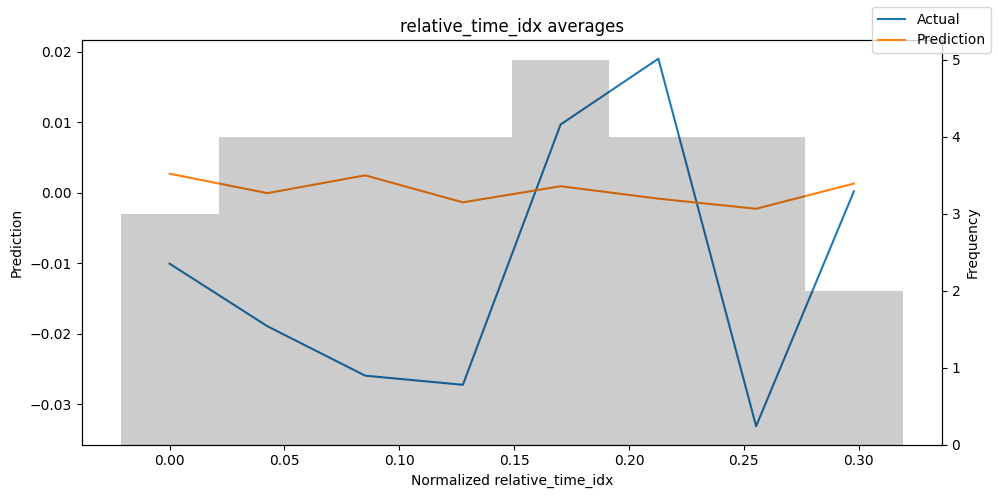

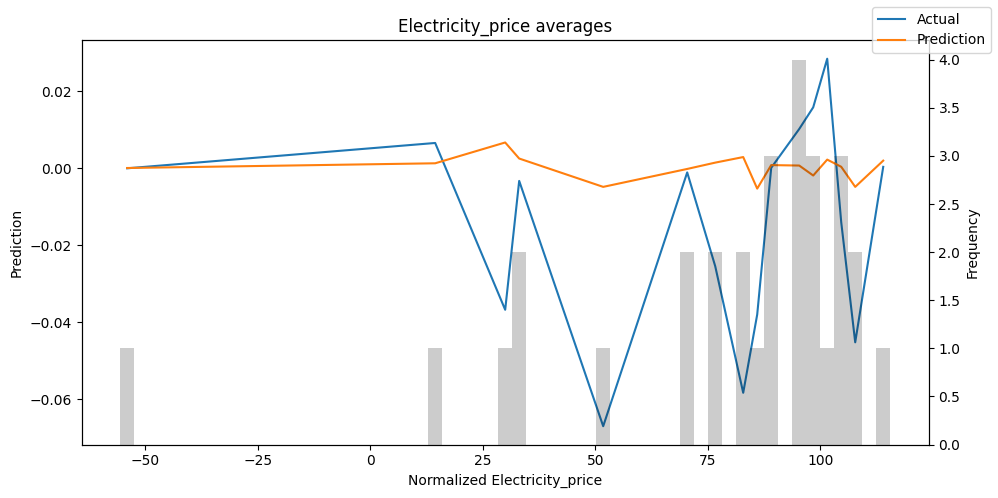

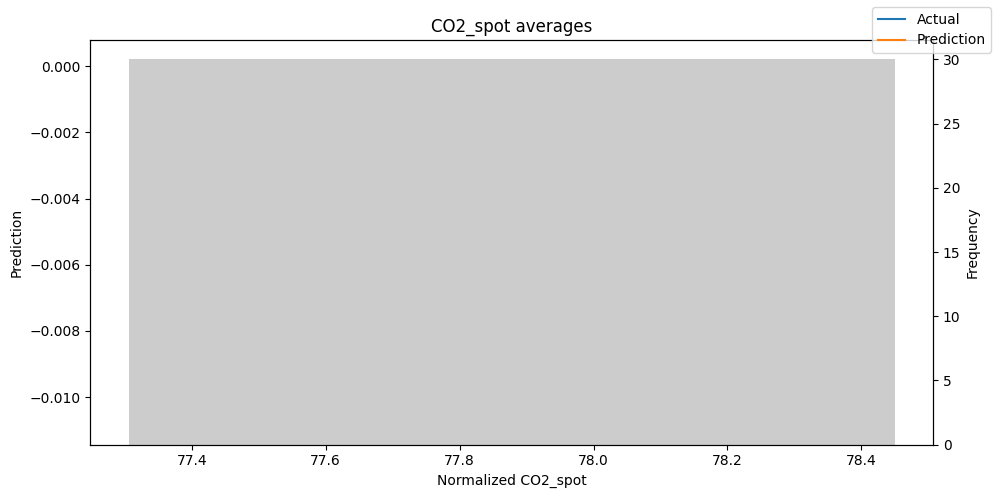

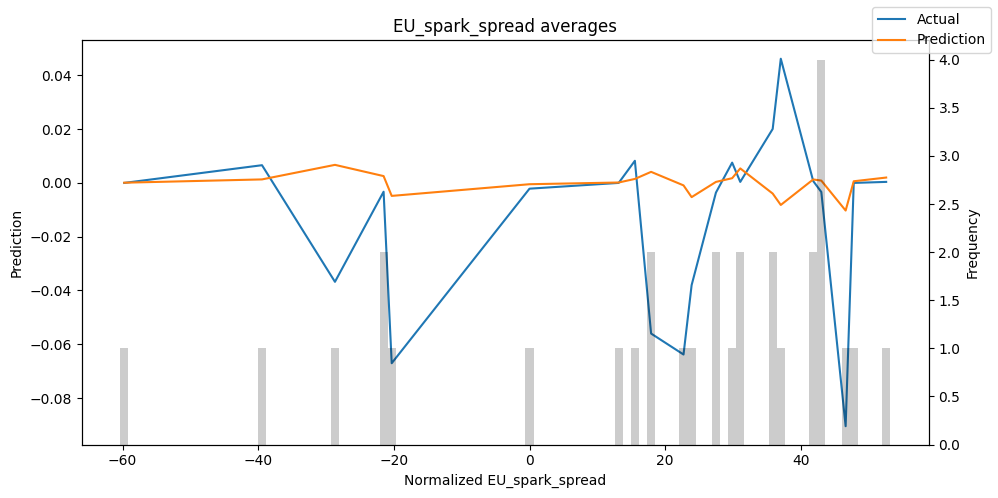

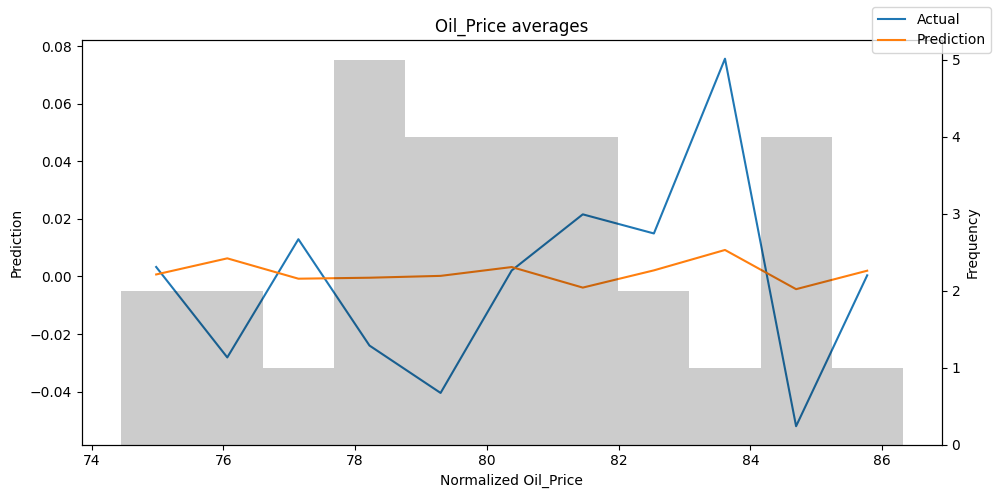

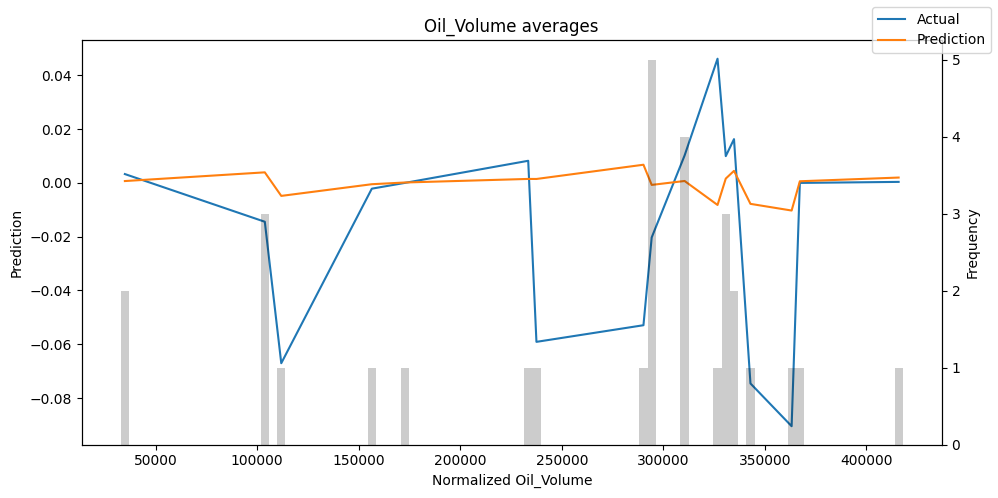

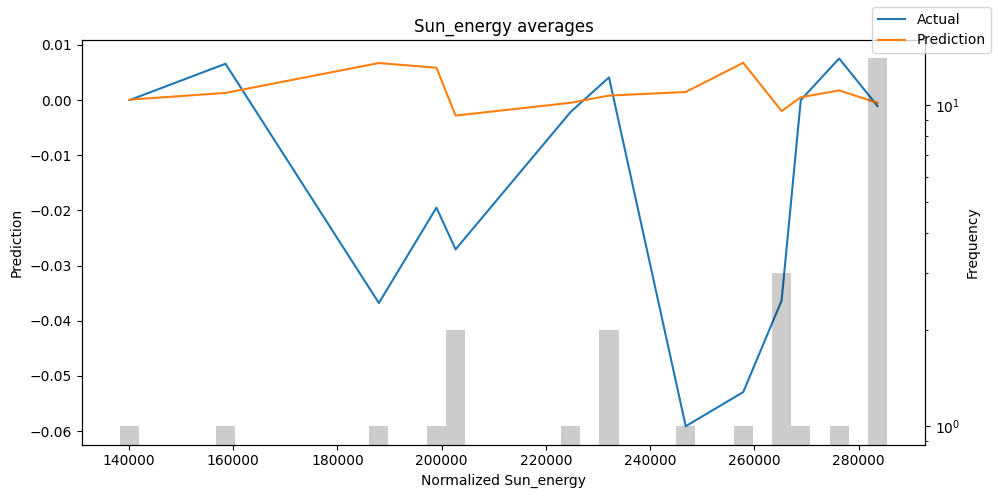

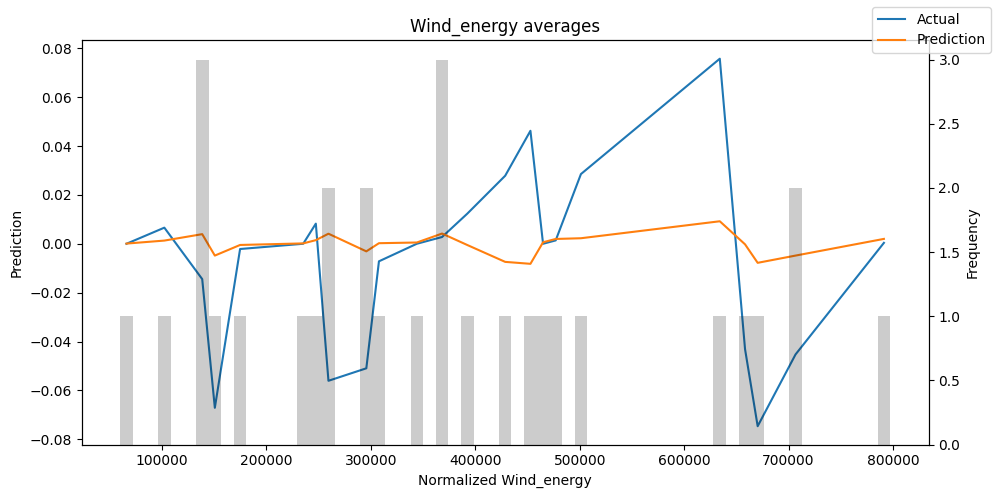

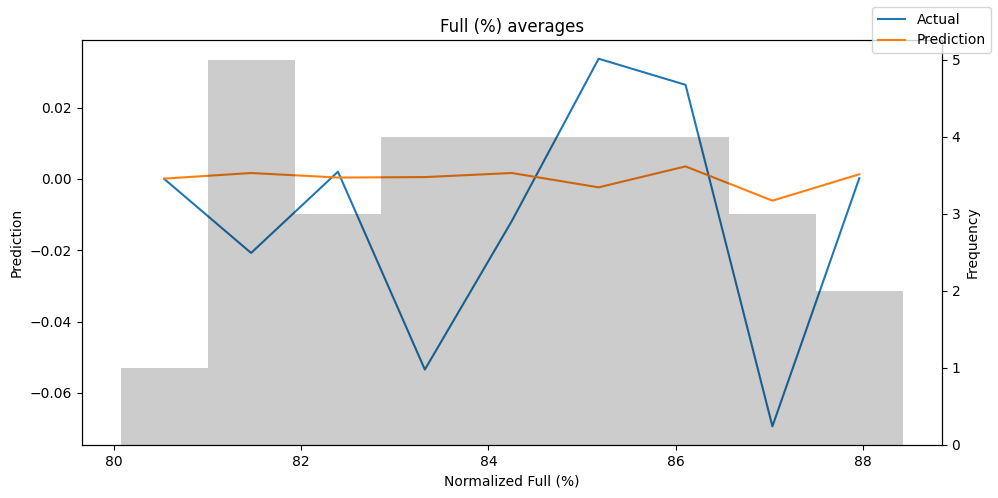

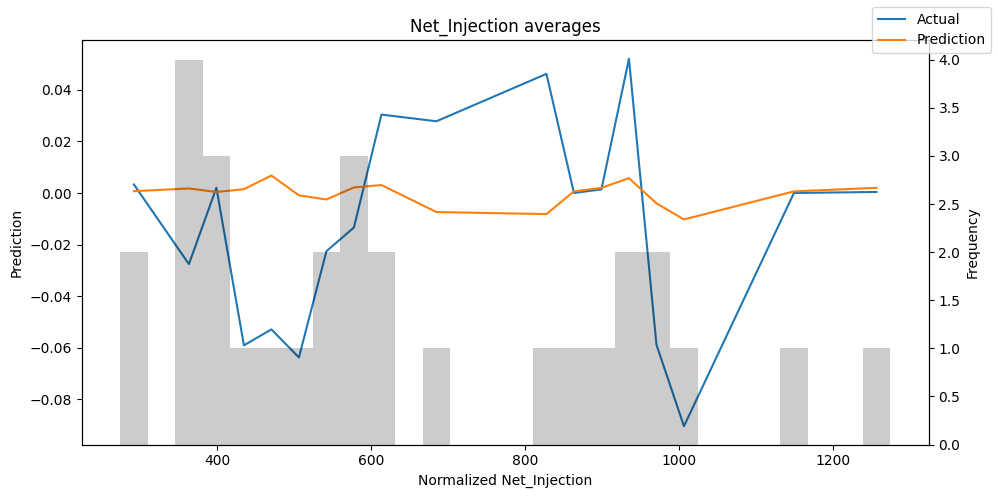

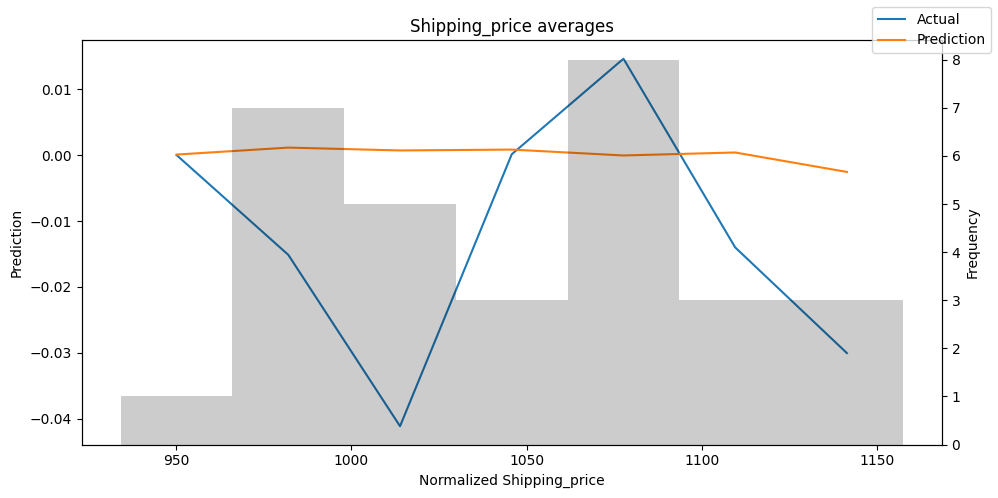

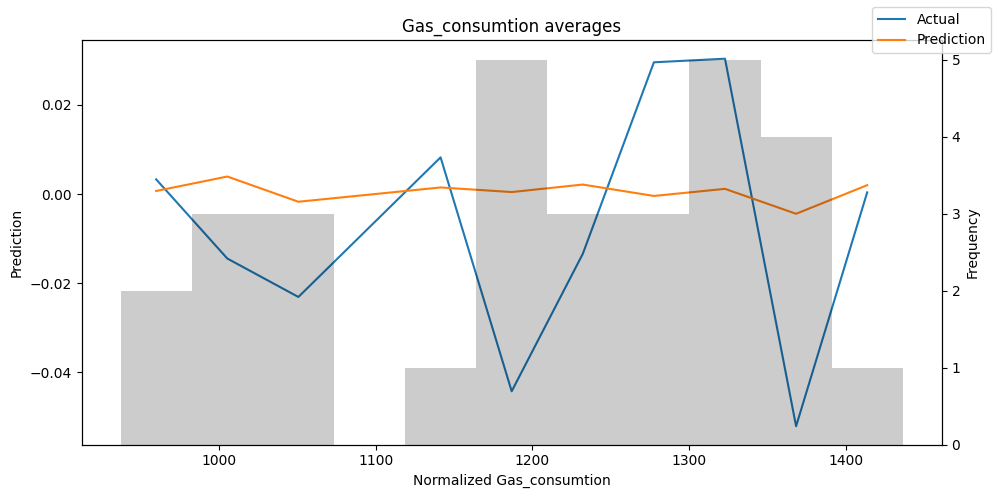

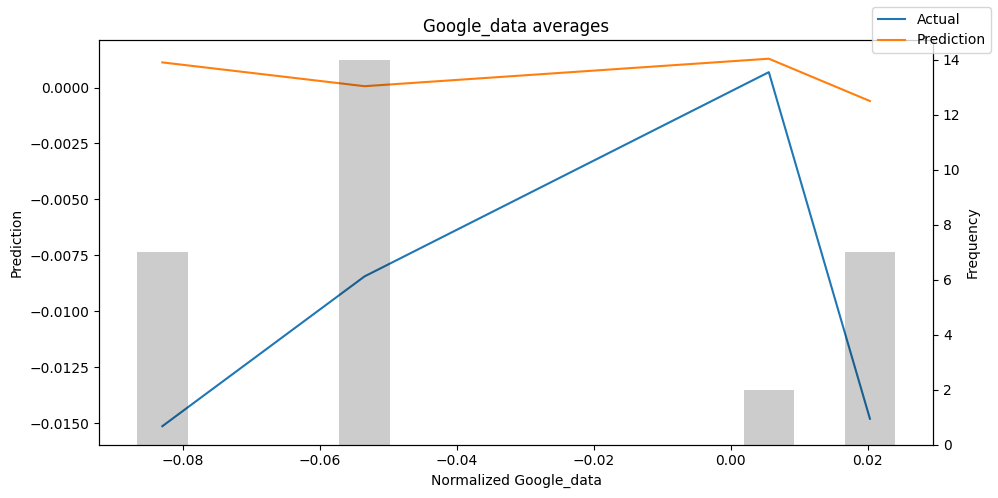

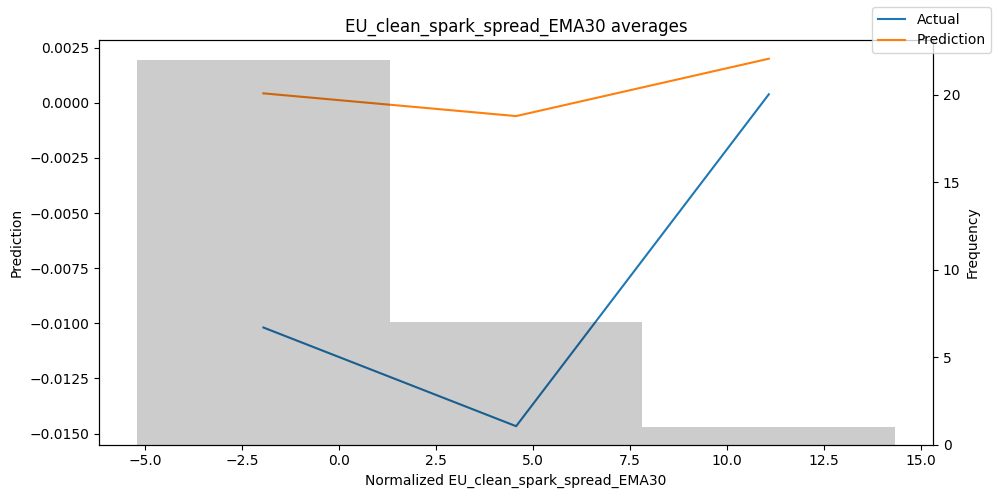

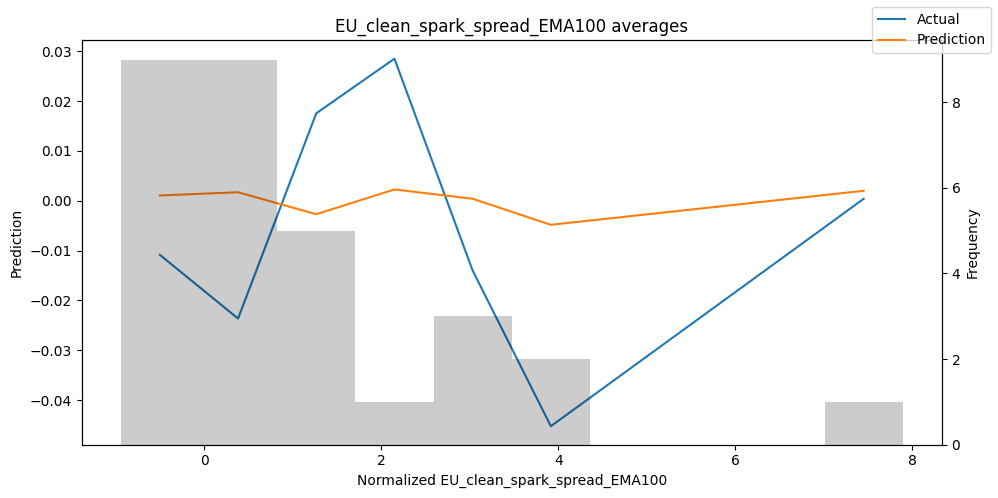

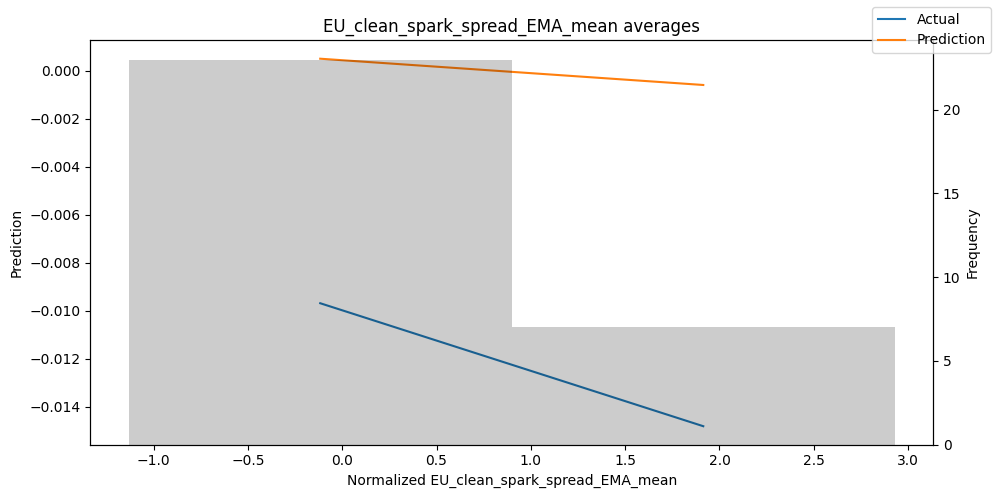

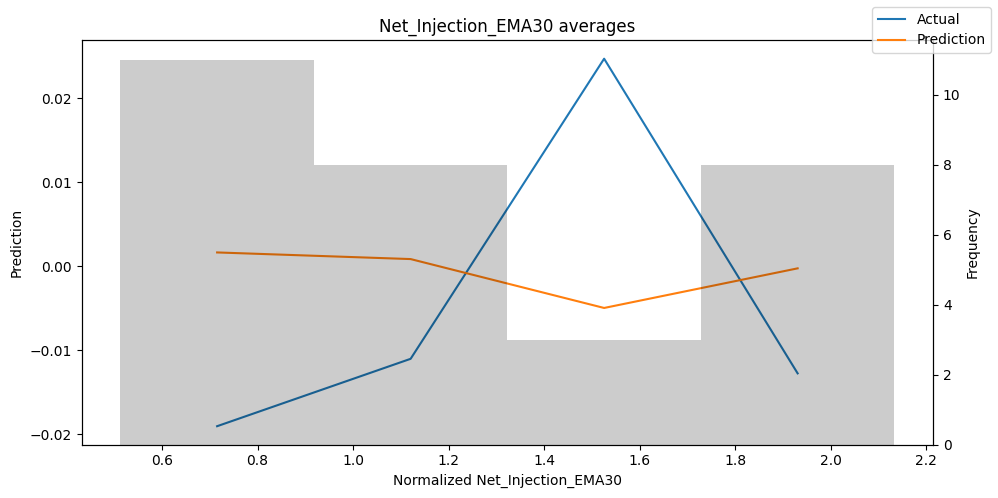

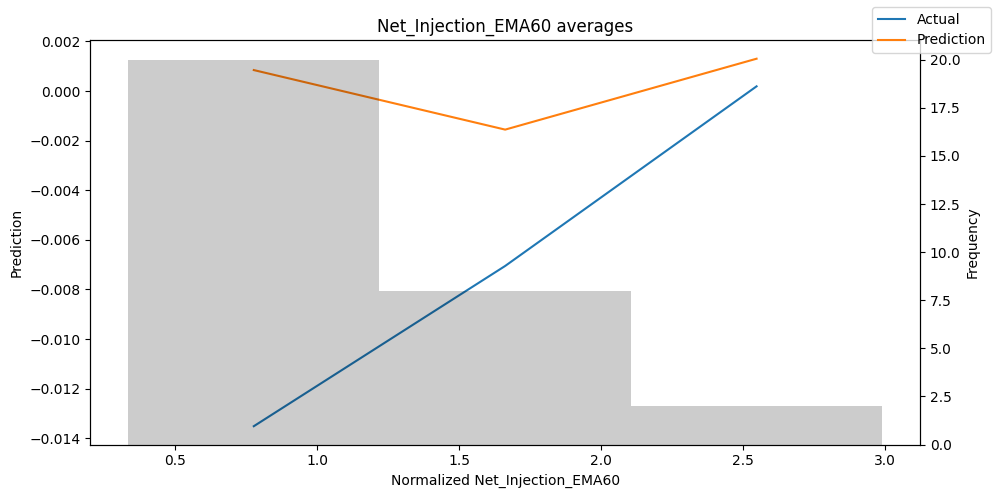

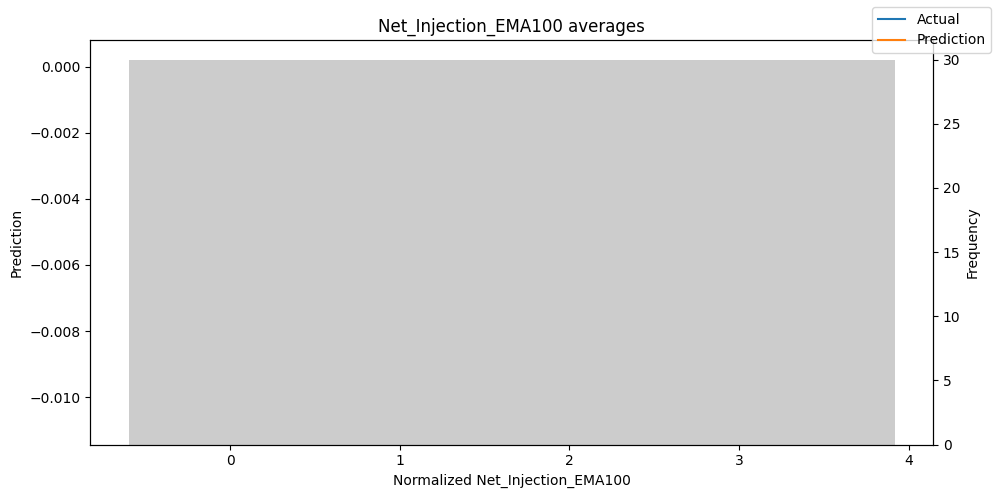

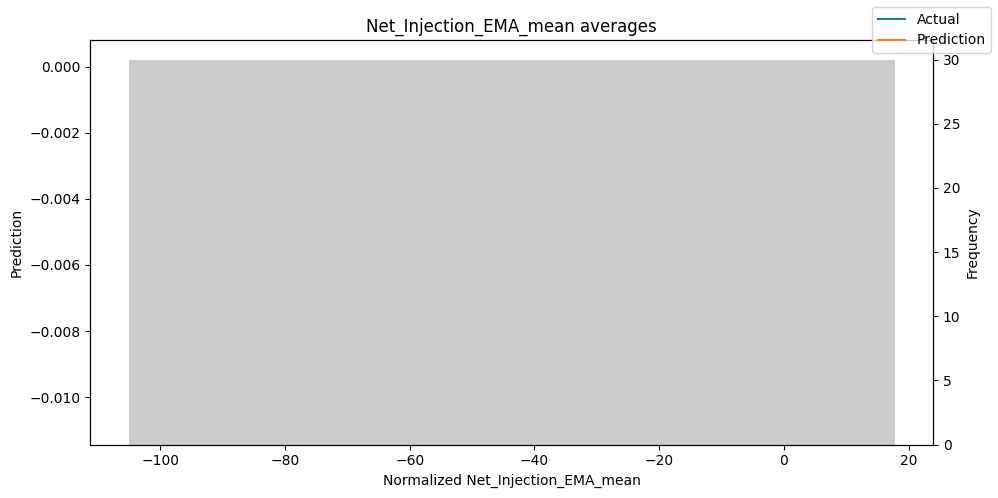

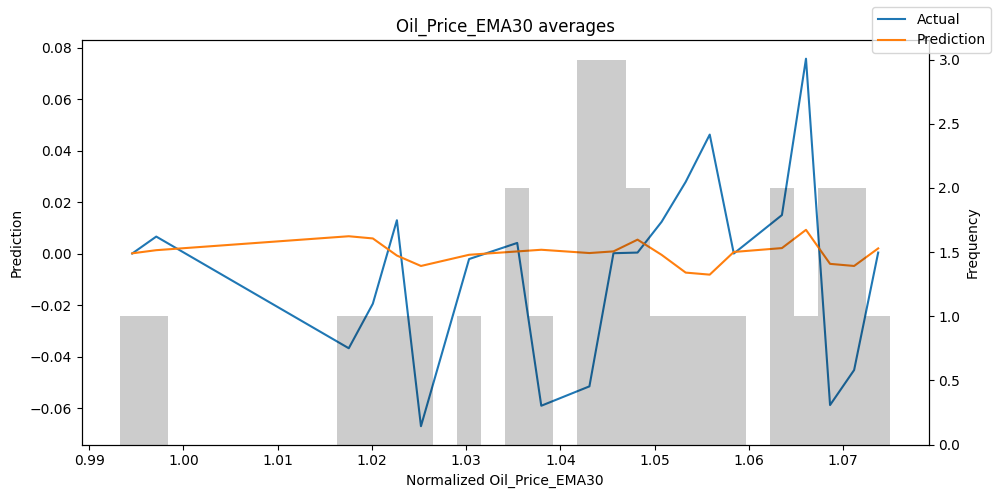

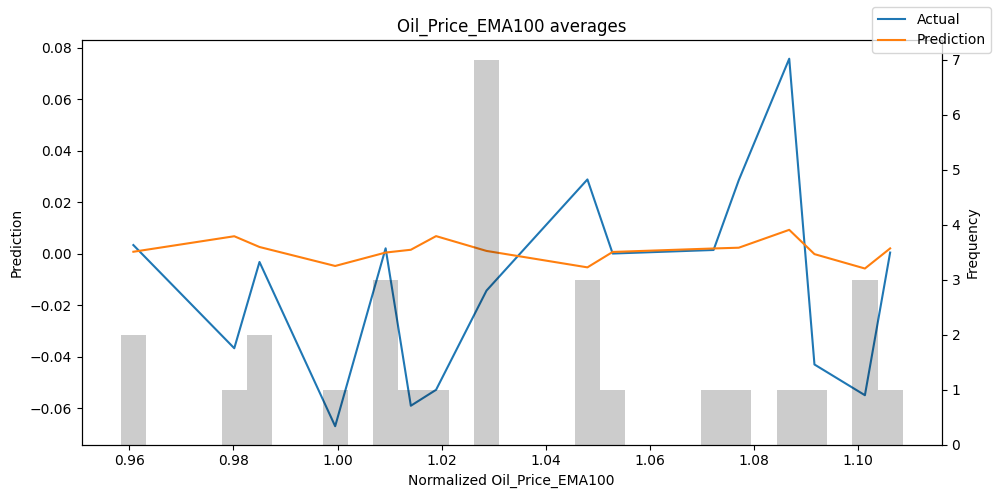

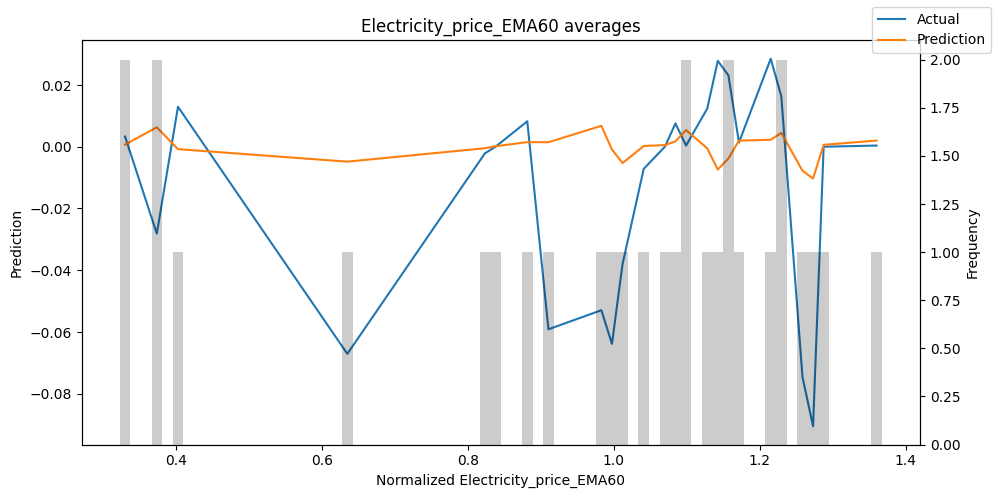

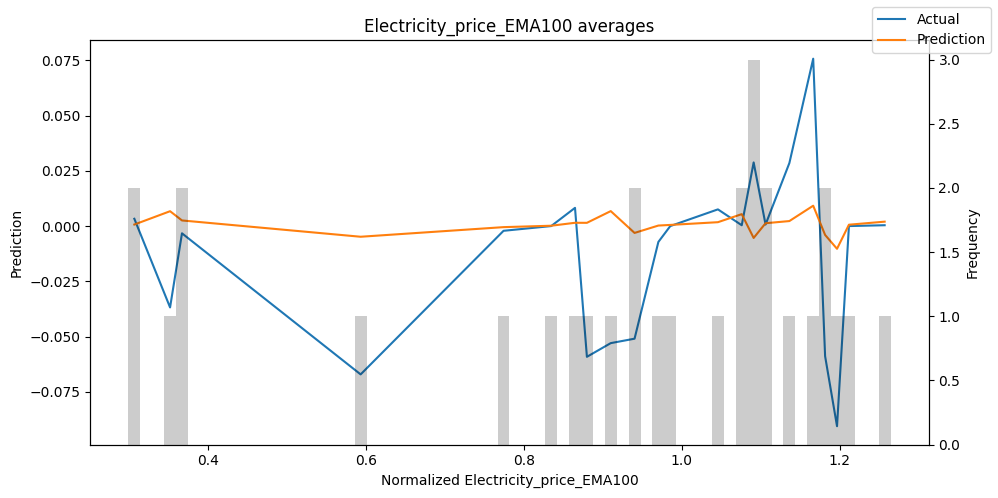

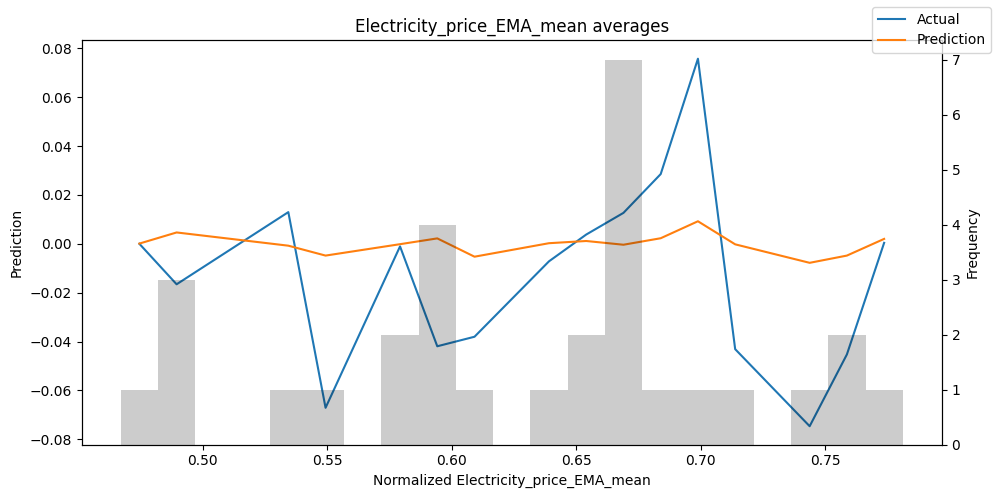

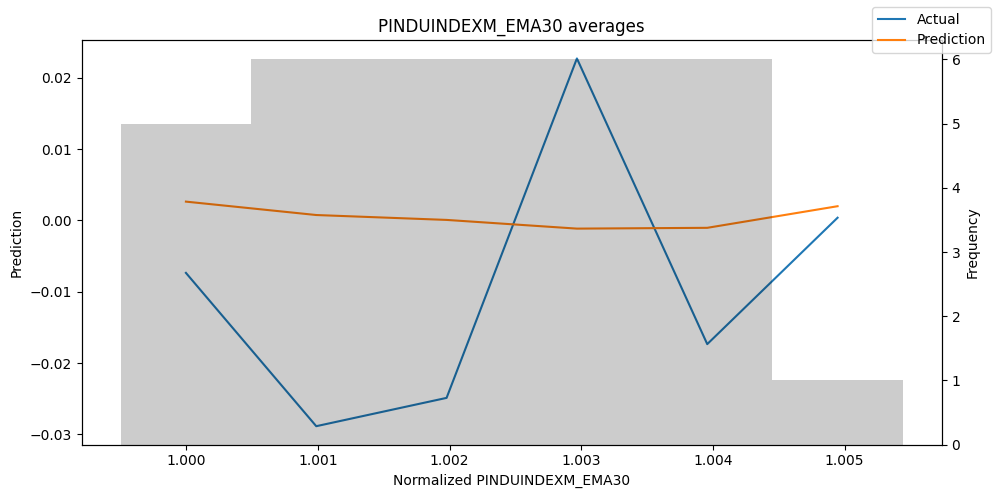

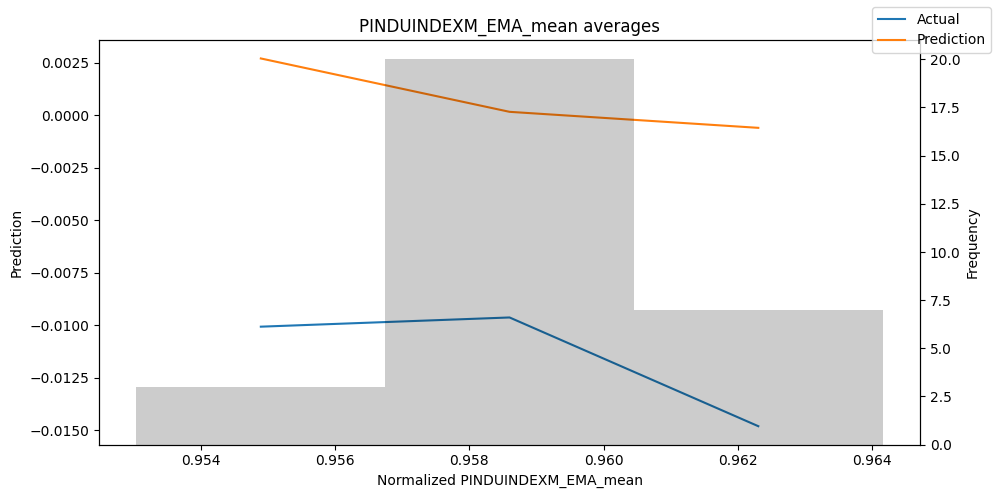

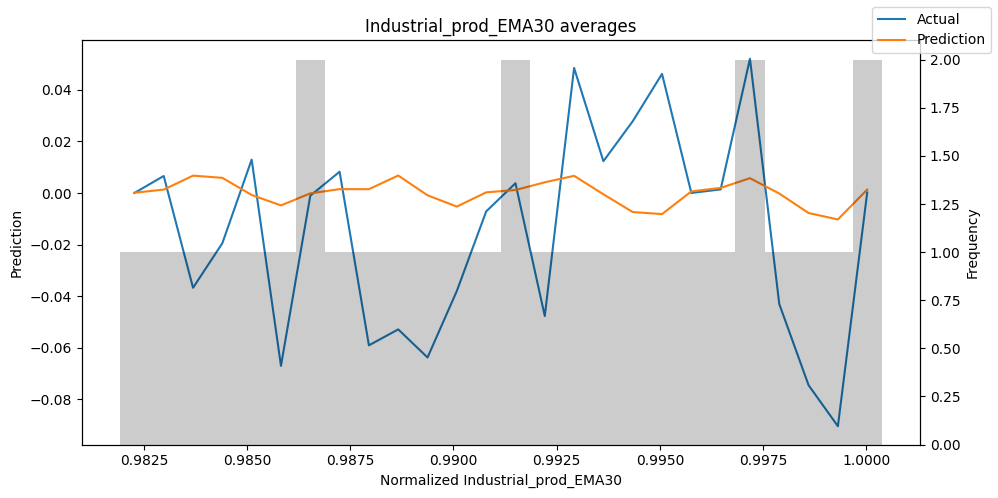

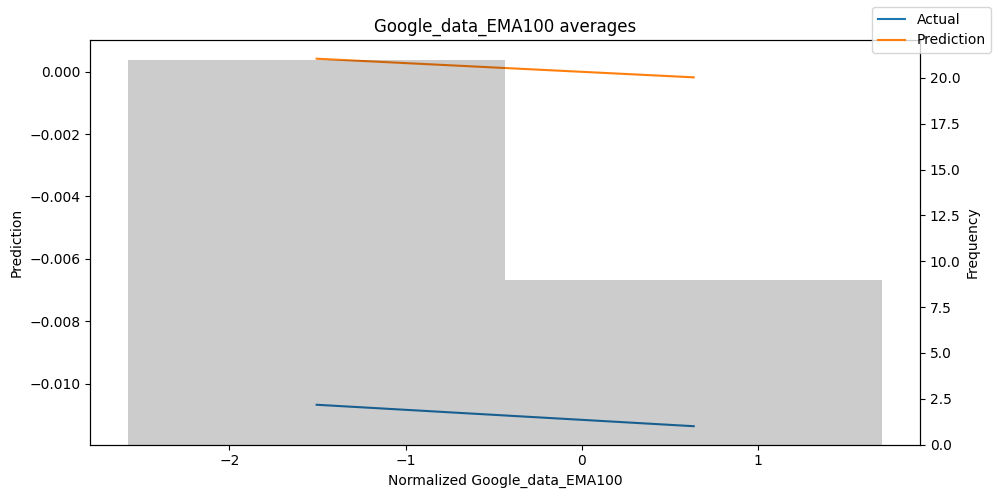

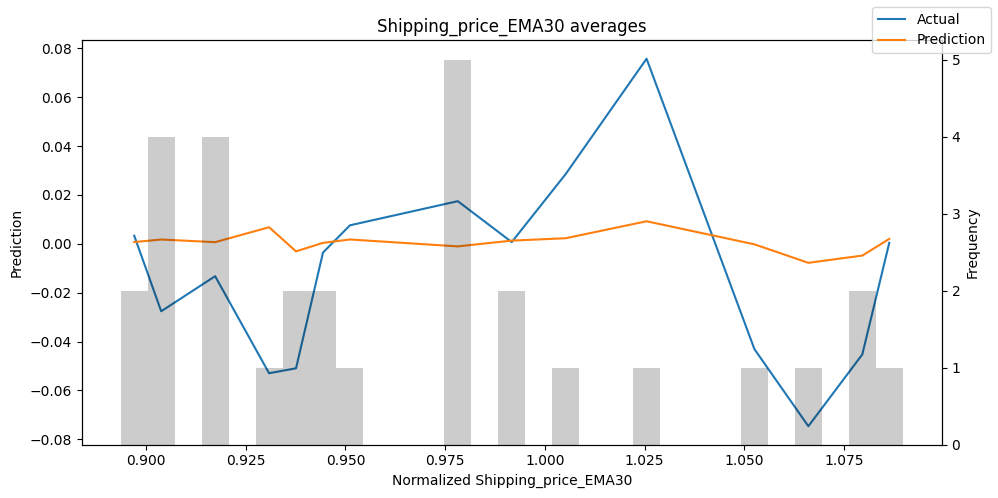

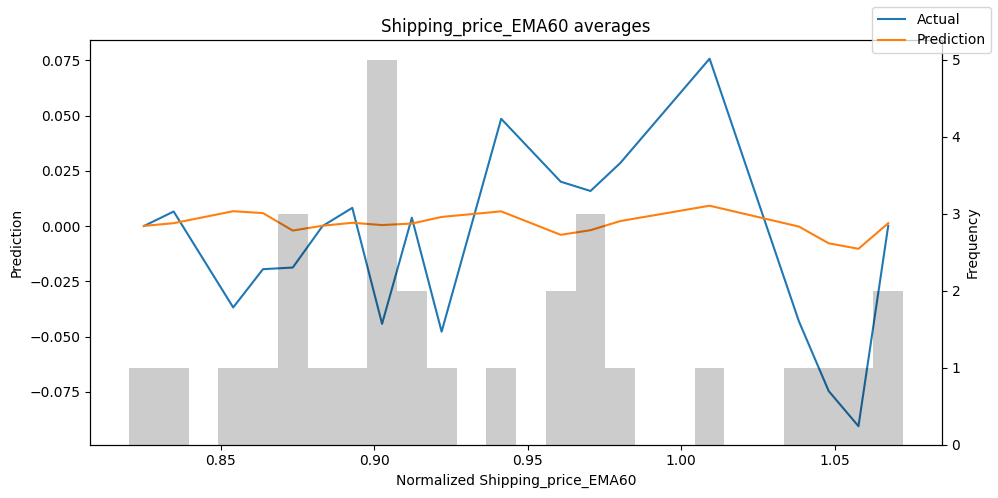

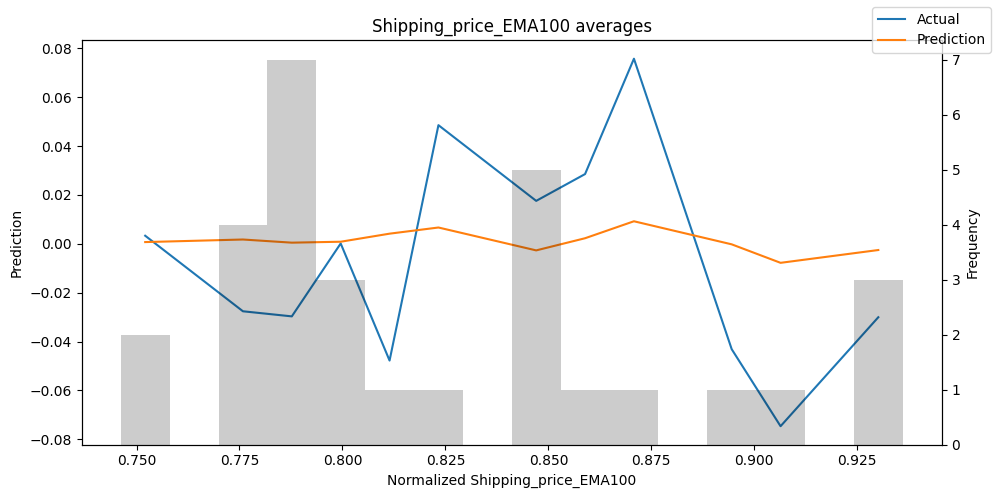

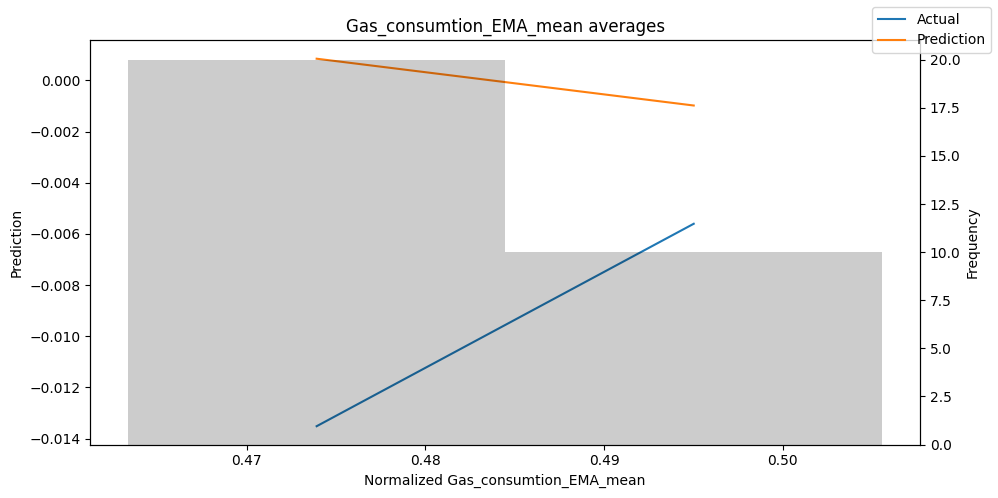

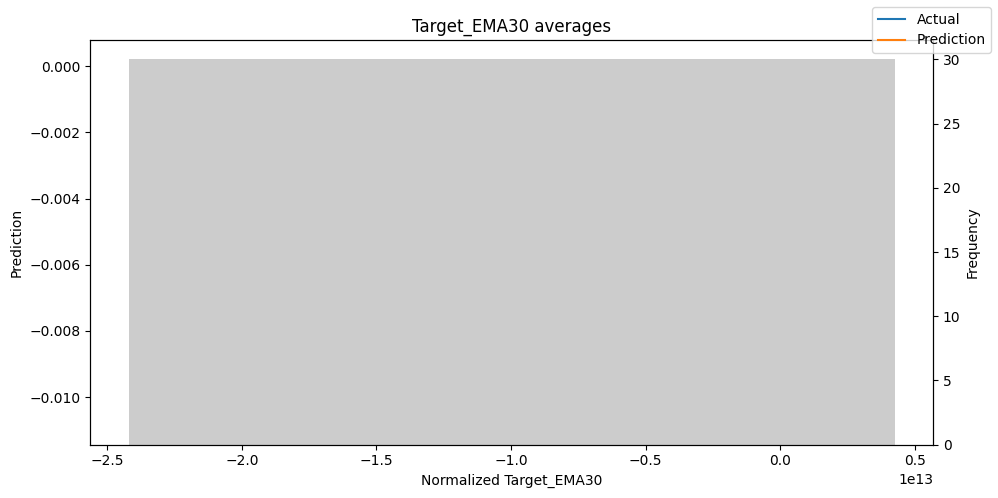

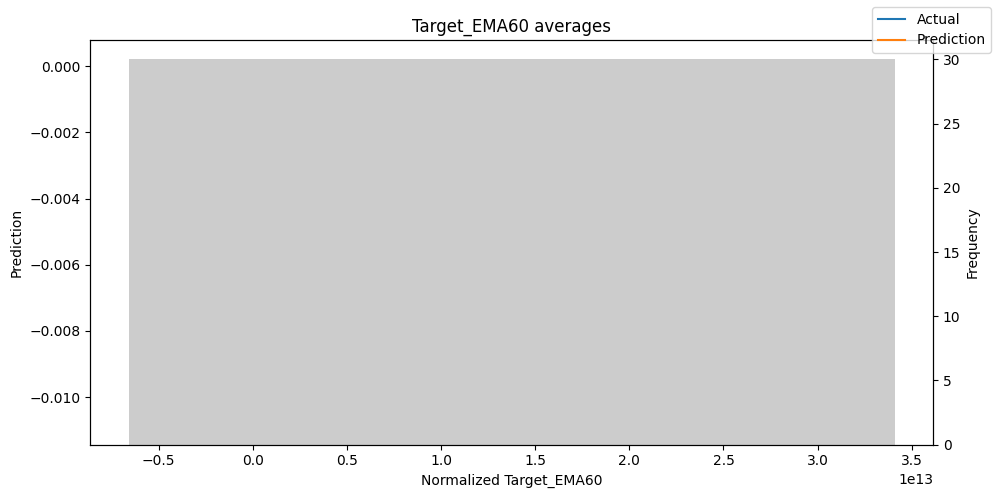

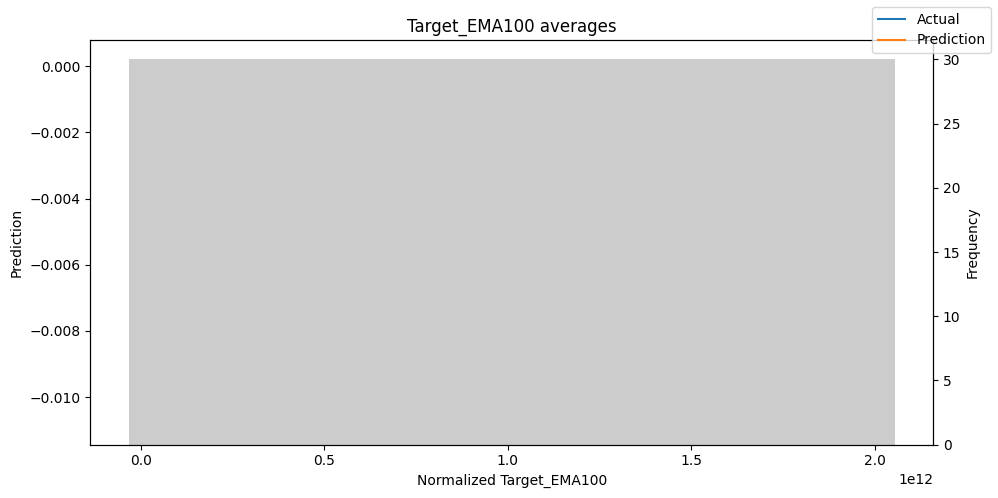

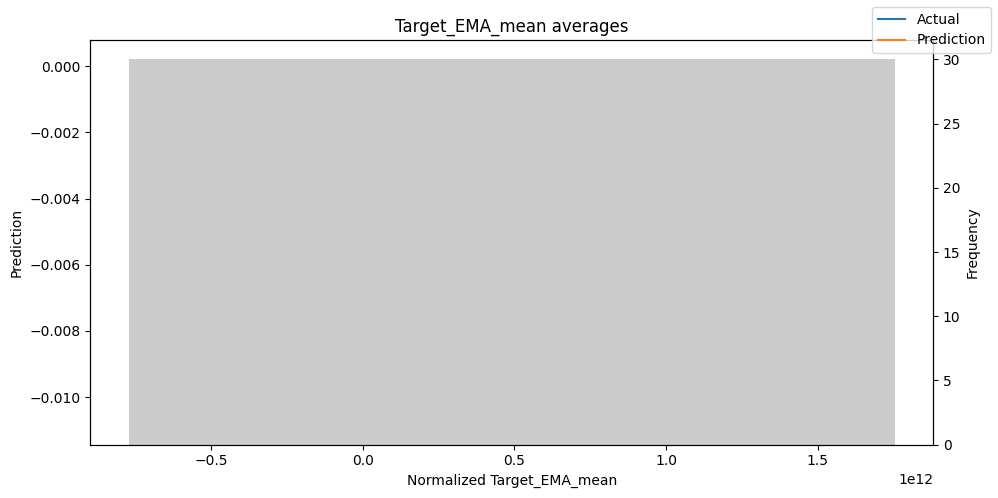

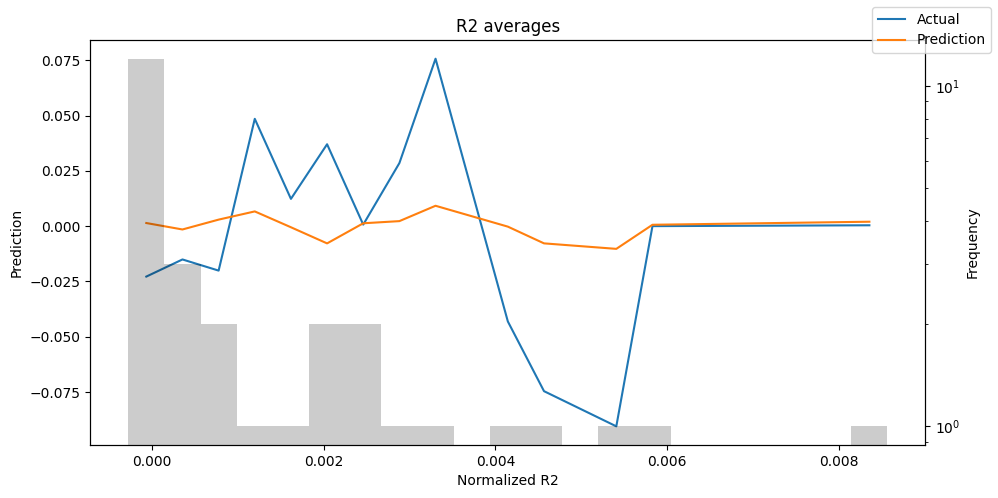

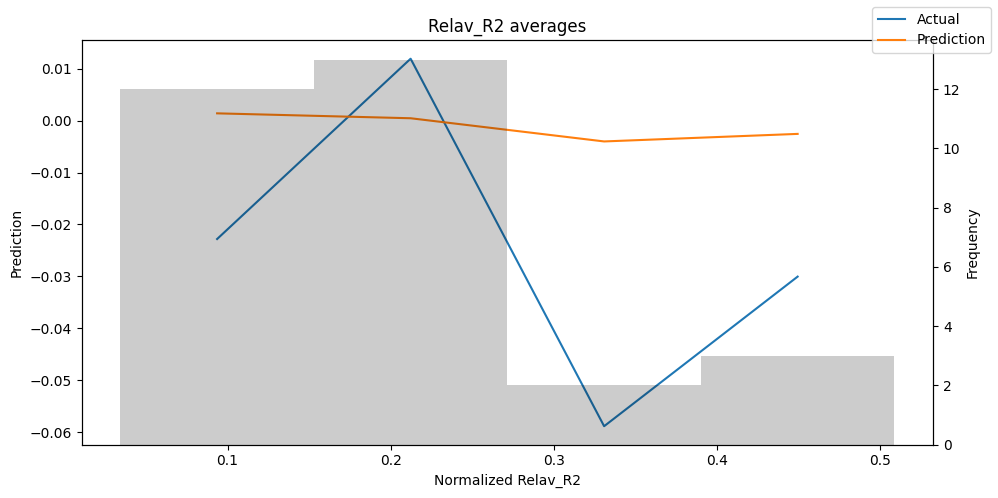

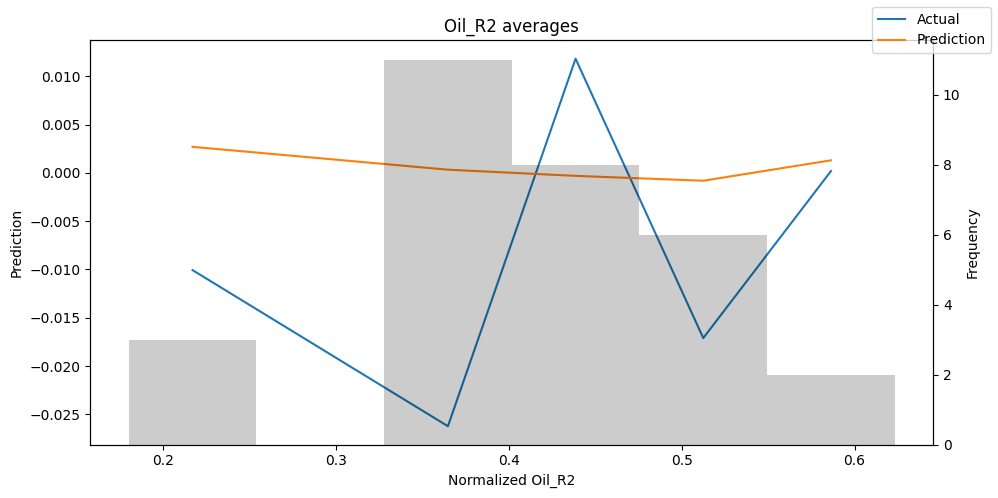

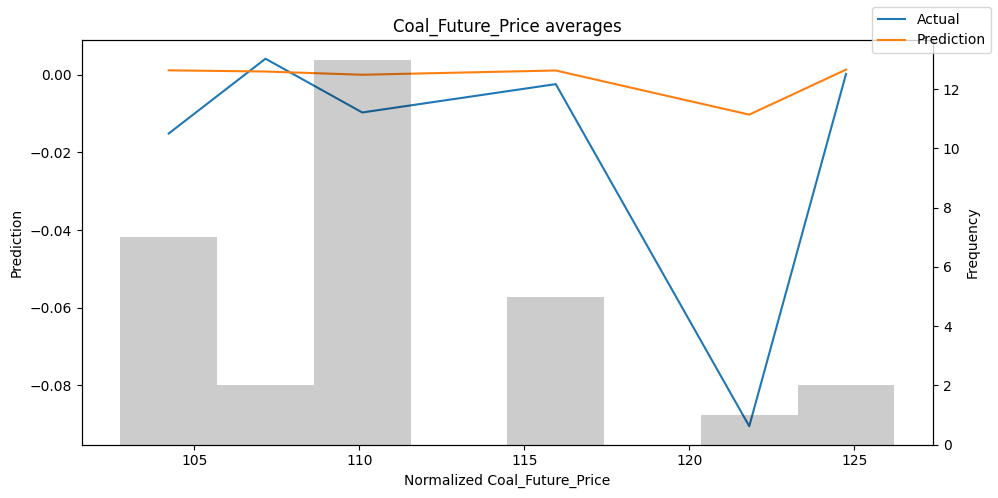

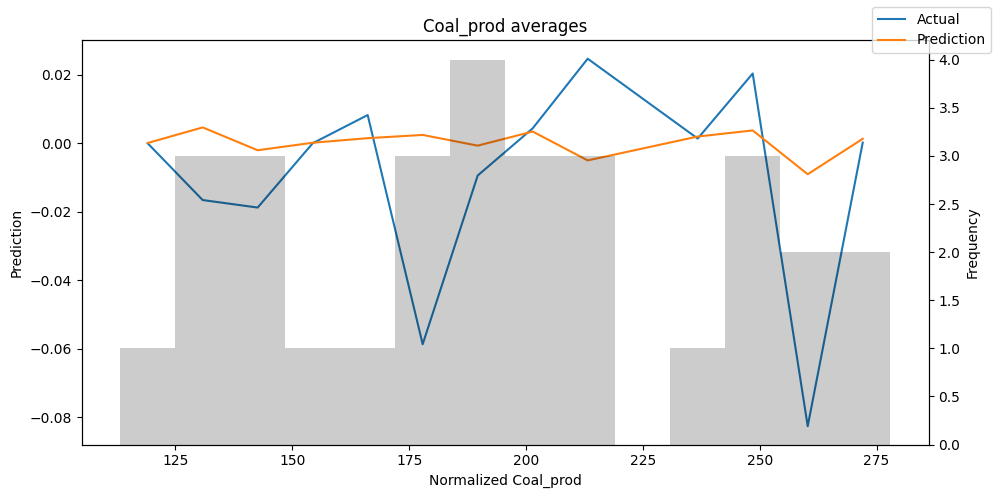

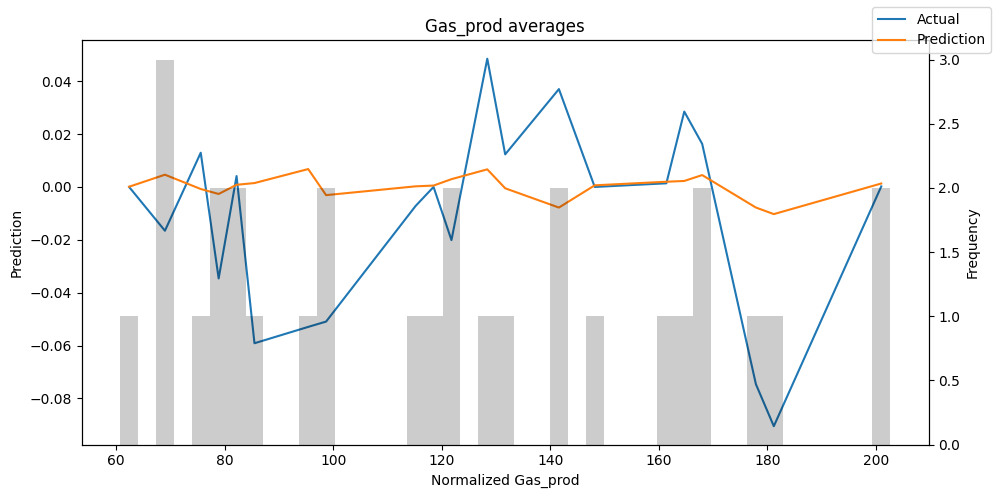

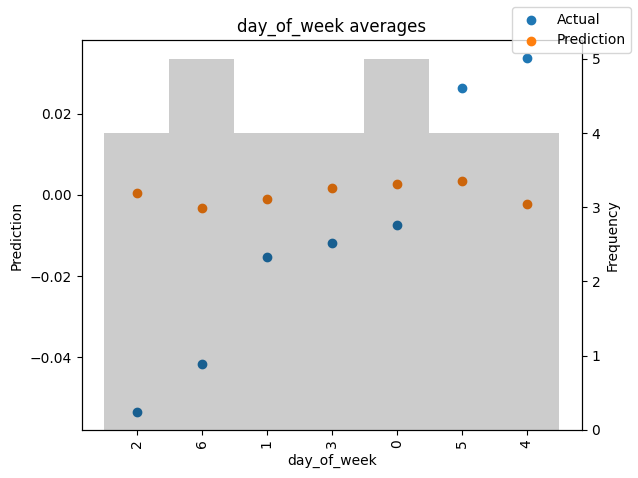

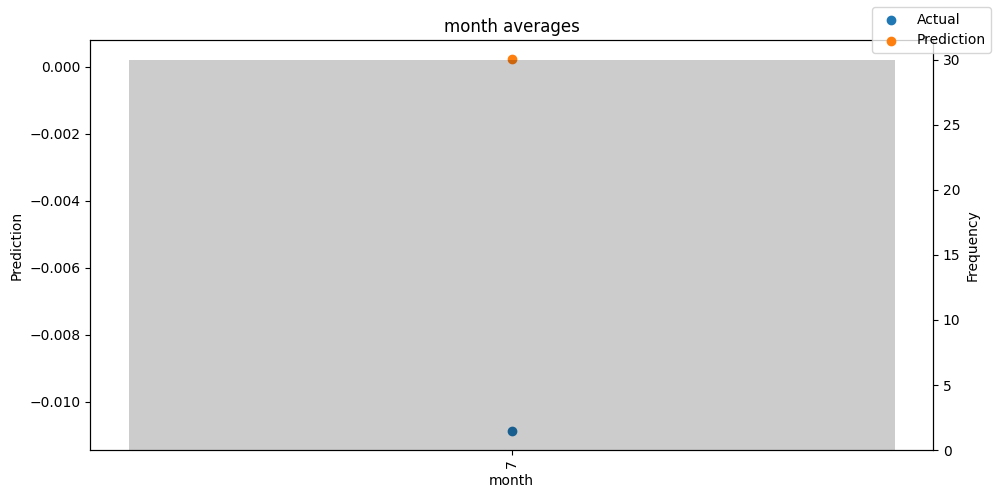

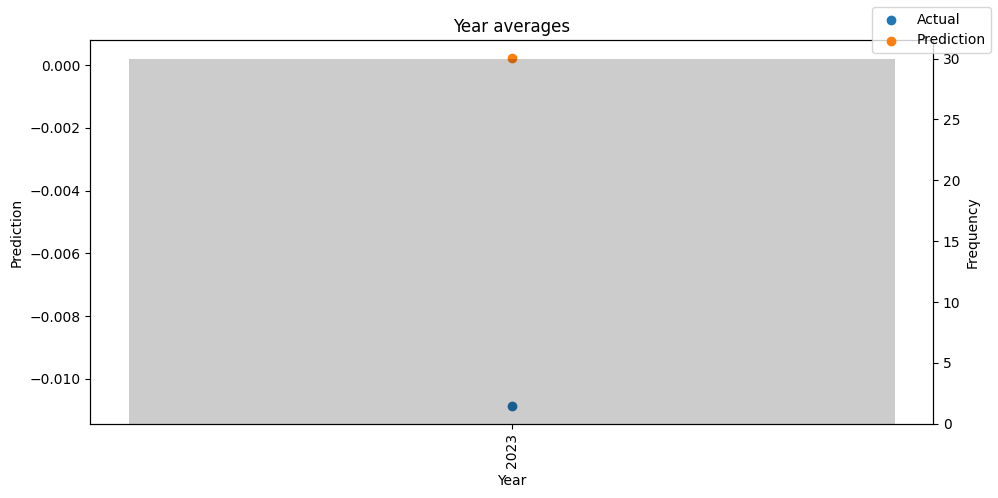

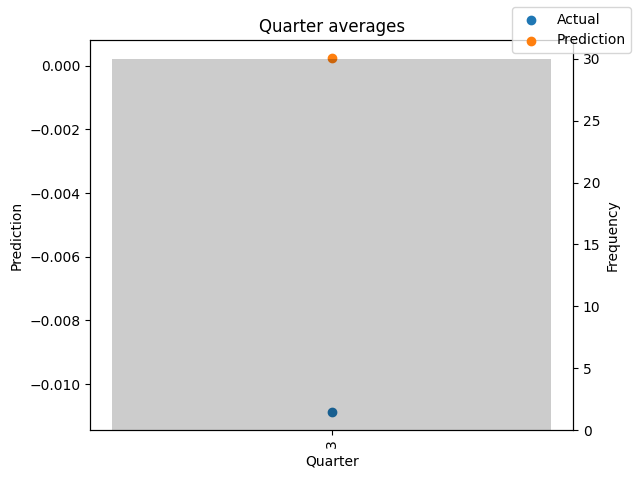

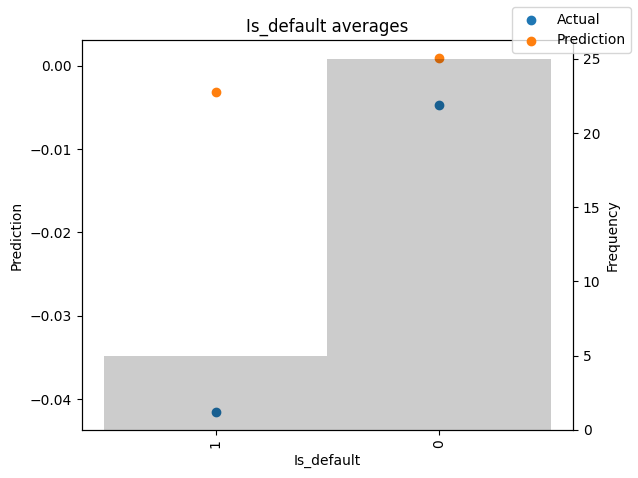

In [184]:
predictions = tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
tft.plot_prediction_actual_by_variable(predictions_vs_actuals)





Predict:   0%|                                                                                                                                                                                                                  | 0/30 [00:00<?, ? batches/s]C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predict:   3%|██████▋                                                        

Predict:  30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 9/30 [00:03<00:08,  2.52 batches/s]C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predict:  33%|█████████████████████████████████████████████████████████████████

Predict:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 18/30 [00:06<00:04,  2.73 batches/s]C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predict:  63%|█████████████████████████████████████████████████████████████████



Predict:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 27/30 [00:09<00:00,  3.37 batches/s]C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Olej0\OneDrive\Dokumenter\TFT_Model\pytorch-forecasting\myenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predict:  93%|███████████████████████████████████████████████████████████████

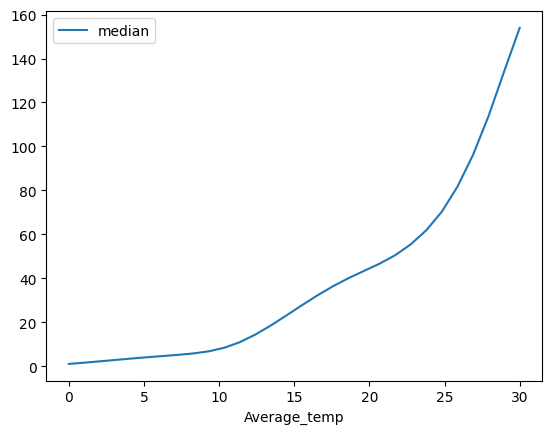

In [103]:
# plotting median and 25% and 75% percentile
dependency = tft.predict_dependency(
    val_dataloader.dataset, "Average_temp", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)
agg_dependency = dependency.groupby("Average_temp").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)